MSRFuseNet - Preprocessing - DWT(3 Features) - PLM - 39  

✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, DWT features per epoch: 15
Valid epochs after masking: 44857


C:\Users\DST\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 1024, 1)]    0           []                               
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 1024, 1)     0           ['ppg_input[0][0]']              
                                                                                                  
 separable_conv1d (SeparableCon  (None, 1024, 32)    79          ['gaussian_noise[0][0]']         
 v1D)                                                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 1024, 32)    128         ['separable_conv1d[0][0]']   

 ing1D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 256, 32)     128         ['separable_conv1d_8[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 32)      0           ['max_pooling1d_1[0][0]',        
                                                                  'average_pooling1d[0][0]']      
                                                                                                  
 add_1 (Add)                    (None, 256, 32)      0           ['batch_normalization_9[0][0]',  
                                                                  'tf.math.subtract[0][0]']       
          

 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32)          128         ['dense_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 concatenate_1 (Concatenate)    (None, 8224)         0           ['flatten[0][0]',                
                                                                  'batch_normalization_14[0][0]'] 
                                                                                                  
 dense_6 (Dense)                (None, 64)           526400      ['concatenate_1[0][0]']          
                                                                                                  
 batch_nor

Epoch 36/100
2620/2620 [==============================] - 199s 76ms/step - loss: 0.1138 - accuracy: 0.7306 - val_loss: 0.1027 - val_accuracy: 0.7052 - lr: 5.0000e-05
Epoch 37/100
2620/2620 [==============================] - 202s 77ms/step - loss: 0.1115 - accuracy: 0.7343 - val_loss: 0.1000 - val_accuracy: 0.7240 - lr: 5.0000e-05
Epoch 38/100
2620/2620 [==============================] - 203s 78ms/step - loss: 0.1112 - accuracy: 0.7365 - val_loss: 0.0997 - val_accuracy: 0.7193 - lr: 5.0000e-05
Epoch 39/100
2620/2620 [==============================] - 205s 78ms/step - loss: 0.1099 - accuracy: 0.7367 - val_loss: 0.0951 - val_accuracy: 0.7321 - lr: 5.0000e-05
Epoch 40/100
2620/2620 [==============================] - 203s 78ms/step - loss: 0.1095 - accuracy: 0.7386 - val_loss: 0.0976 - val_accuracy: 0.7185 - lr: 5.0000e-05
Epoch 41/100
2620/2620 [==============================] - 203s 77ms/step - loss: 0.1082 - accuracy: 0.7385 - val_loss: 0.0965 - val_accuracy: 0.7240 - lr: 5.0000e-05
Epoc

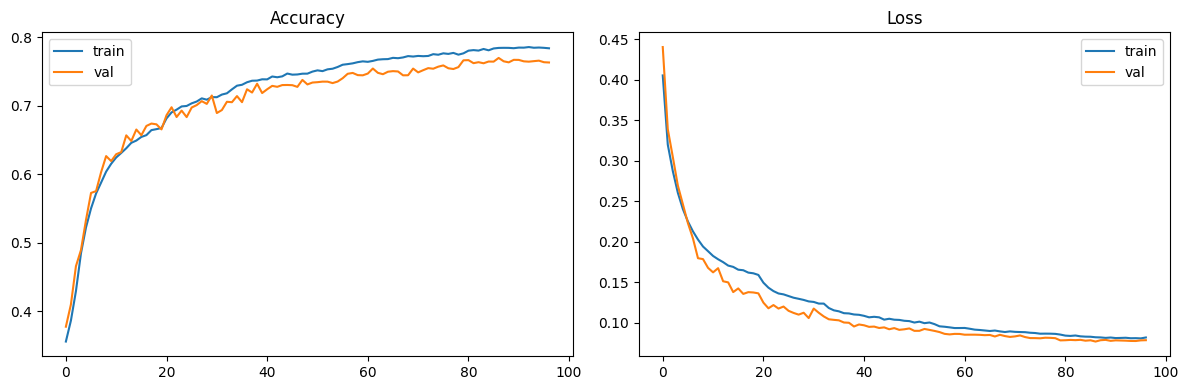

655/655 [==============================] - 13s 17ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.40      0.56      4192
           1       0.99      0.97      0.98      4191
           2       0.59      0.49      0.54      4192
           3       0.99      1.00      0.99      4192
           4       0.57      0.98      0.72      4192

    accuracy                           0.77     20959
   macro avg       0.81      0.77      0.76     20959
weighted avg       0.81      0.77      0.76     20959

[[1683   12 1349   10 1138]
 [   3 4086   23   40   39]
 [ 115   15 2061   11 1990]
 [   0    5    2 4179    6]
 [   1    1   64    1 4125]]

🧠 Cohen Kappa Score: 0.7122


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpzm_ygv9q\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpzm_ygv9q\assets



⏱️ Total training time: 335.43 minutes


In [1]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
import pywt  # Added for DWT

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_FS = 256  # Original sampling frequency
TARGET_FS = 34.3  # Target sampling frequency (from paper)
EPOCH_SAMPLES = 1024  # Samples per epoch at TARGET_FS
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_FS / EPOCH_SAMPLES)  # epochs in 1 hour
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR  # fixed length for each subject
DWT_LEVELS = 4  # Number of DWT decomposition levels
WAVELET = 'db4'  # Wavelet type for DWT

# --- Preprocessing functions ---

def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    nyq = 0.5 * fs
    wp = cutoff / nyq
    b, a = cheby2(order, rs, wp, btype='low', analog=False)
    filtered = filtfilt(b, a, signal)
    return filtered

def poly_detrend(signal, degree=10):
    x = np.arange(len(signal))
    coefs = Polynomial.fit(x, signal, degree).convert().coef
    trend = np.polyval(coefs[::-1], x)
    detrended = signal - trend
    return detrended

def min_max_norm(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    if max_val - min_val == 0:
        return signal * 0  # avoid div by zero if flat signal
    return (signal - min_val) / (max_val - min_val)

def extract_dwt_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    # Perform DWT decomposition
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    # Flatten and compute statistical features (mean, std, energy) for each coefficient
    features = []
    for c in coeffs:
        features.extend([
            np.mean(c), np.std(c), np.sum(c**2)  # Mean, std, energy
        ])
    return np.array(features)

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_FS, target_fs=TARGET_FS,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    # 1. Filter
    filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
    # 2. Detrend
    detrended = poly_detrend(filtered)
    # 3. Min-max normalization
    normalized = min_max_norm(detrended)
    # 4. Resample to target_fs
    up = int(target_fs * 1000)
    down = int(orig_fs * 1000)
    gcd = np.gcd(up, down)
    up //= gcd
    down //= gcd
    resampled = resample_poly(normalized, up, down)
    # 5. Epoching: slice into fixed length segments of epoch_samples
    total_samples = epoch_samples * total_epochs
    if len(resampled) > total_samples:
        resampled = resampled[:total_samples]
    elif len(resampled) < total_samples:
        pad_len = total_samples - len(resampled)
        resampled = np.pad(resampled, (0, pad_len), 'constant')
    # 6. Reshape to epochs
    epochs = resampled.reshape(total_epochs, epoch_samples)
    # Create mask to mark zero-padded epochs
    mask = np.array([0 if np.sum(e) == 0 else 1 for e in epochs])
    # 7. Extract DWT features for each epoch
    dwt_features = np.array([extract_dwt_features(epoch) for epoch in epochs])
    return epochs, dwt_features, mask

# --- Load raw data and preprocess once ---

folder_path = r"D:\abhishek_extracted\plm"
mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]

X_epochs_list = []
X_dwt_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    mat = scipy.io.loadmat(file)
    raw_signal = mat['ppg_signals'].flatten()
    sleep_labels = mat['sleep_stages'].flatten()

    # Preprocess raw signal to epochs + DWT features + mask
    epochs, dwt_features, mask = preprocess_ppg_signal(raw_signal)

    # Adjust sleep labels to epochs length
    if len(sleep_labels) > epochs.shape[0]:
        sleep_labels = sleep_labels[:epochs.shape[0]]
    elif len(sleep_labels) < epochs.shape[0]:
        pad_len = epochs.shape[0] - len(sleep_labels)
        sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)

    X_epochs_list.append(epochs)
    X_dwt_list.append(dwt_features)
    y_epochs_list.append(sleep_labels)
    mask_list.append(mask)

X_all = np.vstack(X_epochs_list)  # shape: (total_epochs * subjects, epoch_samples)
X_dwt_all = np.vstack(X_dwt_list)  # shape: (total_epochs * subjects, dwt_feature_size)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, DWT features per epoch: {X_dwt_all.shape[1]}")

# Save preprocessed data
np.save("ppg_epochs.npy", X_all)
np.save("dwt_features.npy", X_dwt_all)
np.save("sleep_labels.npy", y_all)
np.save("epoch_mask.npy", mask_all)

# --- Filter out zero-padded epochs for training ---
valid_idx = y_all != -1  # remove epochs with padded labels
valid_idx = valid_idx & (mask_all == 1)  # remove zero-padded epochs

X_all = X_all[valid_idx]
X_dwt_all = X_dwt_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")

# --- Data Augmentation ---

def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

# Class-wise augmentation for minority classes
np.random.seed(42)
augmented_ppg = []
augmented_dwt = []
minority_classes = np.where(np.bincount(y_all) < np.median(np.bincount(y_all)))[0]

for ppg, dwt, label in zip(X_all, X_dwt_all, y_all):
    if label in minority_classes:
        if np.random.rand() < 0.5:
            ppg = jitter(ppg)
            dwt = jitter(dwt, sigma=0.005)  # Smaller jitter for DWT features
        if np.random.rand() < 0.5:
            ppg = magnitude_warp(ppg)
            # DWT features are statistical, so avoid warping
        if np.random.rand() < 0.5:
            ppg = scaling(ppg)
            dwt = scaling(dwt, sigma=0.05)  # Smaller scaling for DWT
    augmented_ppg.append(ppg)
    augmented_dwt.append(dwt)

X_aug = np.array(augmented_ppg)
X_dwt_aug = np.array(augmented_dwt)

# --- Standardization ---
scaler_ppg = StandardScaler()
X_scaled = scaler_ppg.fit_transform(X_aug)

scaler_dwt = StandardScaler()
X_dwt_scaled = scaler_dwt.fit_transform(X_dwt_aug)

# --- Handle Class Imbalance with SMOTE ---
# Concatenate PPG and DWT features for SMOTE
X_combined = np.concatenate([X_scaled, X_dwt_scaled], axis=1)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_combined, y_all)

# Split back into PPG and DWT
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_dwt = X_res[:, X_scaled.shape[1]:]

# --- Class weights ---
class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# --- Train-test split ---
X_train_ppg, X_test_ppg, X_train_dwt, X_test_dwt, y_train, y_test = train_test_split(
    X_res_ppg, X_res_dwt, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# Expand dims for CNN input
X_train_ppg = X_train_ppg[..., np.newaxis]
X_test_ppg = X_test_ppg[..., np.newaxis]

# One-hot encoding
num_classes = 5
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# --- Focal loss ---
def focal_loss(gamma=1.5, alpha=[0.1, 0.7, 0.2, 1.0, 0.7]):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, dwt_shape):
    reg = l2(1e-4)
    
    # PPG Input Branch (CNN)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)

    # First CNN Block
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)

    # MSR-SE Block
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)

    # Second Conv Block + Residual
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)

    # Frequency Fusion Block
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)

    # Third Conv Block
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)

    # Attention
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation="relu", kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation="sigmoid", kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])

    # Residual Merge
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)

    # DWT Input Branch (MLP)
    dwt_input = Input(shape=dwt_shape, name='dwt_input')
    d = GaussianNoise(0.02)(dwt_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    dwt_out = d

    # Combine PPG and DWT branches
    combined = Concatenate()([ppg_out, dwt_out])

    # RVFL Dense Layers
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=[ppg_input, dwt_input], outputs=outputs)

# --- Compile & train ---
model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_dwt.shape[1],))
model.compile(optimizer=Adam(2e-4),  # Slightly increased learning rate
              loss=focal_loss(gamma=1.5, alpha=[0.1, 0.7, 0.2, 1.0, 0.7]),
              metrics=['accuracy'])

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_dwt.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

history = model.fit([X_train_ppg, X_train_dwt], y_train_cat, 
                    validation_data=([X_test_ppg, X_test_dwt], y_test_cat),
                    epochs=100, batch_size=32, class_weight=class_weight_dict,
                    callbacks=callbacks, verbose=1)

end_time = time.time()

# --- Plot training curves ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- Evaluation ---
y_pred = model.predict([X_test_ppg, X_test_dwt])
y_pred_cls = np.argmax(y_pred, axis=1)
y_true_cls = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_cls, y_pred_cls))

cm = confusion_matrix(y_true_cls, y_pred_cls)
print(cm)

kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")

# --- Save model ---
model.save("cnn_dwt_rvfl_light_model.keras")

# --- Export TFLite ---
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("cnn_dwt_rvfl_light_model.tflite", "wb") as f:
    f.write(tflite_model)

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

In [2]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")



✅ Overall Test Accuracy: 0.8207


MSRFuseNet - Preprocessing - DWT(3 Features) - PLM - 39 - PROPER ALPHA STRATEGY

✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, DWT features per epoch: 15
Valid epochs after masking: 44857

Class Distribution Before Augmentation:
Class 0: 20959 samples (46.72%)
Class 1: 3768 samples (8.40%)
Class 2: 14564 samples (32.47%)
Class 3: 1784 samples (3.98%)
Class 4: 3782 samples (8.43%)

Class Distribution After Augmentation:
Class 0: 33615 samples (41.93%)
Class 1: 9458 samples (11.80%)
Class 2: 23211 samples (28.95%)
Class 3: 4467 samples (5.57%)
Class 4: 9414 samples (11.74%)


C:\Users\DST\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Class Distribution After SMOTE:
Class 0: 33615 samples (20.00%)
Class 1: 33615 samples (20.00%)
Class 2: 33615 samples (20.00%)
Class 3: 33615 samples (20.00%)
Class 4: 33615 samples (20.00%)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 1024, 1)]    0           []                               
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 1024, 1)     0           ['ppg_input[0][0]']              
                                                                                                  
 separable_conv1d (SeparableCon  (None, 1024, 32)    79          ['gaussian_noise[0][0]']         
 v1D)                                                                                             


                                                                                                  
 average_pooling1d (AveragePool  (None, 256, 32)     0           ['max_pooling1d_1[0][0]']        
 ing1D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 256, 32)     128         ['separable_conv1d_8[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 32)      0           ['max_pooling1d_1[0][0]',        
                                                                  'average_pooling1d[0][0]']      
                                                                                                  
 add_1 (Ad

 dense_5 (Dense)                (None, 32)           2080        ['dropout[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32)          128         ['dense_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 concatenate_1 (Concatenate)    (None, 8224)         0           ['flatten[0][0]',                
                                                                  'batch_normalization_14[0][0]'] 
                                                                                                  
 dense_6 (

4202/4202 [==============================] - 347s 82ms/step - loss: 0.2023 - accuracy: 0.7727 - val_loss: 0.1683 - val_accuracy: 0.8130 - lr: 5.0000e-05
Epoch 84/100
4202/4202 [==============================] - 348s 83ms/step - loss: 0.2031 - accuracy: 0.7714 - val_loss: 0.1703 - val_accuracy: 0.8118 - lr: 5.0000e-05
Epoch 85/100
4202/4202 [==============================] - 347s 83ms/step - loss: 0.2013 - accuracy: 0.7735 - val_loss: 0.1692 - val_accuracy: 0.8095 - lr: 5.0000e-05
Epoch 86/100
4202/4202 [==============================] - 345s 82ms/step - loss: 0.1997 - accuracy: 0.7753 - val_loss: 0.1694 - val_accuracy: 0.8095 - lr: 5.0000e-05
Epoch 87/100
4202/4202 [==============================] - 351s 83ms/step - loss: 0.1941 - accuracy: 0.7788 - val_loss: 0.1669 - val_accuracy: 0.8123 - lr: 2.5000e-05
Epoch 88/100
4202/4202 [==============================] - 352s 84ms/step - loss: 0.1934 - accuracy: 0.7809 - val_loss: 0.1653 - val_accuracy: 0.8163 - lr: 2.5000e-05
Epoch 89/100
4202

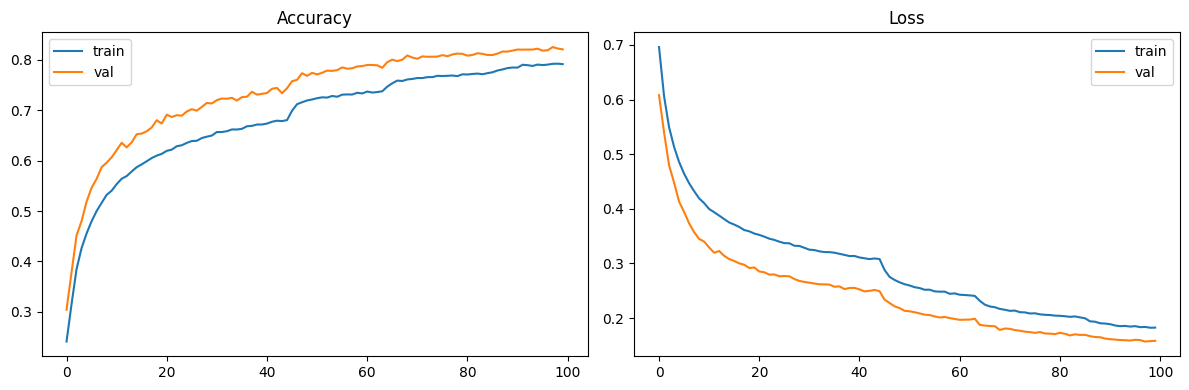

1051/1051 [==============================] - 18s 17ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.66      0.74      6723
           1       0.82      0.89      0.85      6723
           2       0.72      0.66      0.69      6723
           3       0.91      0.99      0.95      6723
           4       0.81      0.90      0.85      6723

    accuracy                           0.82     33615
   macro avg       0.82      0.82      0.82     33615
weighted avg       0.82      0.82      0.82     33615

Confusion Matrix:
[[4412  403 1415  118  375]
 [  95 5986  160   98  384]
 [ 670  586 4454  333  680]
 [   3   28   18 6657   17]
 [  44  332  142  127 6078]]

🧠 Cohen Kappa Score: 0.7758


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp_u6wxdpe\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp_u6wxdpe\assets



⏱️ Total training time: 566.21 minutes


In [1]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
import pywt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_FS = 256
TARGET_FS = 34.3
EPOCH_SAMPLES = 1024
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_FS / EPOCH_SAMPLES)
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR
DWT_LEVELS = 4
WAVELET = 'db4'

# --- Preprocessing functions ---
def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    nyq = 0.5 * fs
    wp = cutoff / nyq
    b, a = cheby2(order, rs, wp, btype='low', analog=False)
    filtered = filtfilt(b, a, signal)
    return filtered

def poly_detrend(signal, degree=10):
    x = np.arange(len(signal))
    coefs = Polynomial.fit(x, signal, degree).convert().coef
    trend = np.polyval(coefs[::-1], x)
    detrended = signal - trend
    return detrended

def min_max_norm(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    if max_val - min_val == 0:
        return signal * 0
    return (signal - min_val) / (max_val - min_val)

def extract_dwt_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    features = []
    for c in coeffs:
        features.extend([np.mean(c), np.std(c), np.sum(c**2)])
    return np.array(features)

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_FS, target_fs=TARGET_FS,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
    detrended = poly_detrend(filtered)
    normalized = min_max_norm(detrended)
    up = int(target_fs * 1000)
    down = int(orig_fs * 1000)
    gcd = np.gcd(up, down)
    up //= gcd
    down //= gcd
    resampled = resample_poly(normalized, up, down)
    total_samples = epoch_samples * total_epochs
    if len(resampled) > total_samples:
        resampled = resampled[:total_samples]
    elif len(resampled) < total_samples:
        pad_len = total_samples - len(resampled)
        resampled = np.pad(resampled, (0, pad_len), 'constant')
    epochs = resampled.reshape(total_epochs, epoch_samples)
    mask = np.array([0 if np.sum(e) == 0 else 1 for e in epochs])
    dwt_features = np.array([extract_dwt_features(epoch) for epoch in epochs])
    return epochs, dwt_features, mask

# --- Load raw data and preprocess ---
folder_path = r"D:\abhishek_extracted\plm"
mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]

X_epochs_list = []
X_dwt_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    mat = scipy.io.loadmat(file)
    raw_signal = mat['ppg_signals'].flatten()
    sleep_labels = mat['sleep_stages'].flatten()
    epochs, dwt_features, mask = preprocess_ppg_signal(raw_signal)
    if len(sleep_labels) > epochs.shape[0]:
        sleep_labels = sleep_labels[:epochs.shape[0]]
    elif len(sleep_labels) < epochs.shape[0]:
        pad_len = epochs.shape[0] - len(sleep_labels)
        sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)
    X_epochs_list.append(epochs)
    X_dwt_list.append(dwt_features)
    y_epochs_list.append(sleep_labels)
    mask_list.append(mask)

X_all = np.vstack(X_epochs_list)
X_dwt_all = np.vstack(X_dwt_list)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, DWT features per epoch: {X_dwt_all.shape[1]}")

# Save preprocessed data
np.save("ppg_epochs.npy", X_all)
np.save("dwt_features.npy", X_dwt_all)
np.save("sleep_labels.npy", y_all)
np.save("epoch_mask.npy", mask_all)

# --- Filter out zero-padded epochs ---
valid_idx = y_all != -1
valid_idx = valid_idx & (mask_all == 1)
X_all = X_all[valid_idx]
X_dwt_all = X_dwt_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")

# --- Print class distribution before augmentation ---
print("\nClass Distribution Before Augmentation:")
unique, counts = np.unique(y_all, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_all)*100:.2f}%)")

# --- Data Augmentation ---
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

# Augment all classes, lighter for majority classes
np.random.seed(42)
augmented_ppg = []
augmented_dwt = []
augmented_labels = []
majority_classes = [0, 2]  # Stage 0 and Stage 2

for ppg, dwt, label in zip(X_all, X_dwt_all, y_all):
    augmented_ppg.append(ppg)
    augmented_dwt.append(dwt)
    augmented_labels.append(label)
    if label in majority_classes:
        # Lighter augmentation for Classes 0 and 2
        if np.random.rand() < 0.3:  # Lower probability
            aug_ppg = jitter(ppg, sigma=0.005)  # Smaller sigma
            aug_dwt = jitter(dwt, sigma=0.002)
            augmented_ppg.append(aug_ppg)
            augmented_dwt.append(aug_dwt)
            augmented_labels.append(label)
        if np.random.rand() < 0.3:
            aug_ppg = scaling(ppg, sigma=0.05)
            aug_dwt = scaling(dwt, sigma=0.02)
            augmented_ppg.append(aug_ppg)
            augmented_dwt.append(aug_dwt)
            augmented_labels.append(label)
    else:
        # Stronger augmentation for Classes 1, 3, 4
        if np.random.rand() < 0.5:
            aug_ppg = jitter(ppg)
            aug_dwt = jitter(dwt, sigma=0.005)
            augmented_ppg.append(aug_ppg)
            augmented_dwt.append(aug_dwt)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = magnitude_warp(ppg)
            aug_dwt = dwt  # No warping for DWT
            augmented_ppg.append(aug_ppg)
            augmented_dwt.append(aug_dwt)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = scaling(ppg)
            aug_dwt = scaling(dwt, sigma=0.05)
            augmented_ppg.append(aug_ppg)
            augmented_dwt.append(aug_dwt)
            augmented_labels.append(label)

X_aug = np.array(augmented_ppg)
X_dwt_aug = np.array(augmented_dwt)
y_aug = np.array(augmented_labels)

# --- Print class distribution after augmentation ---
print("\nClass Distribution After Augmentation:")
unique, counts = np.unique(y_aug, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_aug)*100:.2f}%)")

# --- Standardization ---
scaler_ppg = StandardScaler()
X_scaled = scaler_ppg.fit_transform(X_aug)
scaler_dwt = StandardScaler()
X_dwt_scaled = scaler_dwt.fit_transform(X_dwt_aug)

# --- Handle Class Imbalance with SMOTE ---
X_combined = np.concatenate([X_scaled, X_dwt_scaled], axis=1)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_combined, y_aug)

# --- Print class distribution after SMOTE ---
print("\nClass Distribution After SMOTE:")
unique, counts = np.unique(y_res, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_res)*100:.2f}%)")

# Split back into PPG and DWT
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_dwt = X_res[:, X_scaled.shape[1]:]

# --- Class weights ---
class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# --- Train-test split ---
X_train_ppg, X_test_ppg, X_train_dwt, X_test_dwt, y_train, y_test = train_test_split(
    X_res_ppg, X_res_dwt, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# Expand dims for CNN input
X_train_ppg = X_train_ppg[..., np.newaxis]
X_test_ppg = X_test_ppg[..., np.newaxis]

# One-hot encoding
num_classes = 5
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# --- Focal loss ---
def focal_loss(gamma=1.5, alpha=[0.3, 0.7, 0.4, 1.0, 0.7]):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, dwt_shape):
    reg = l2(1e-4)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation="relu", kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation="sigmoid", kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)
    dwt_input = Input(shape=dwt_shape, name='dwt_input')
    d = GaussianNoise(0.02)(dwt_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    dwt_out = d
    combined = Concatenate()([ppg_out, dwt_out])
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=[ppg_input, dwt_input], outputs=outputs)

# --- Compile & train ---
model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_dwt.shape[1],))
model.compile(optimizer=Adam(2e-4),
              loss=focal_loss(gamma=1.5, alpha=[0.3, 0.7, 0.4, 1.0, 0.7]),
              metrics=['accuracy'])

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_dwt.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

history = model.fit([X_train_ppg, X_train_dwt], y_train_cat,
                    validation_data=([X_test_ppg, X_test_dwt], y_test_cat),
                    epochs=100, batch_size=32, class_weight=class_weight_dict,
                    callbacks=callbacks, verbose=1)

end_time = time.time()

# --- Plot training curves ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- Evaluation ---
y_pred = model.predict([X_test_ppg, X_test_dwt])
y_pred_cls = np.argmax(y_pred, axis=1)
y_true_cls = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_cls, y_pred_cls))

cm = confusion_matrix(y_true_cls, y_pred_cls)
print("Confusion Matrix:")
print(cm)

kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")

# --- Save model ---
model.save("cnn_dwt_rvfl_light_model.keras")

# --- Export TFLite ---
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("cnn_dwt_rvfl_light_model.tflite", "wb") as f:
    f.write(tflite_model)

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

In [3]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")



✅ Overall Test Accuracy: 0.8207


In [4]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Macro F1 Score:", f1_score(y_true_cls, y_pred_cls, average='macro'))
print("Weighted F1 Score:", f1_score(y_true_cls, y_pred_cls, average='weighted'))
print("Macro Precision:", precision_score(y_true_cls, y_pred_cls, average='macro'))
print("Macro Recall:", recall_score(y_true_cls, y_pred_cls, average='macro'))


Macro F1 Score: 0.8159912037898691
Weighted F1 Score: 0.8159912037898691
Macro Precision: 0.8189742966519843
Macro Recall: 0.8206752937676633


In [5]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
print(f"📉 Final Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")



📈 Final Accuracy: Train = 0.7914, Val = 0.8207
📉 Final Loss: Train = 0.1826, Val = 0.1584


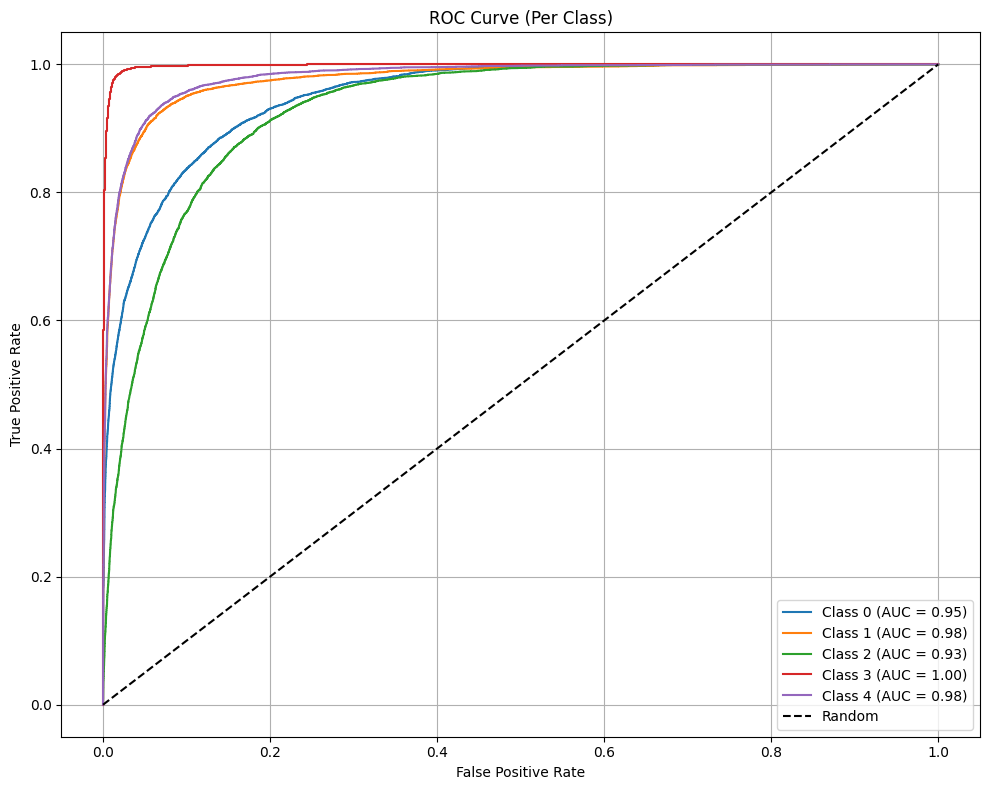

In [6]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure y_test is binarized
n_classes = 5
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


MSRFuseNet - Preprocessing - DWT(5 Features) - PLM - 39 - (SKEWNESS AND KURTOSIS)

✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, DWT features per epoch: 25
Valid epochs after masking: 44857

Class Distribution Before Augmentation:
Class 0: 20959 samples (46.72%)
Class 1: 3768 samples (8.40%)
Class 2: 14564 samples (32.47%)
Class 3: 1784 samples (3.98%)
Class 4: 3782 samples (8.43%)

Class Distribution After Augmentation:
Class 0: 33720 samples (42.01%)
Class 1: 9294 samples (11.58%)
Class 2: 23326 samples (29.06%)
Class 3: 4436 samples (5.53%)
Class 4: 9494 samples (11.83%)


C:\Users\DST\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Class Distribution After SMOTE:
Class 0: 33720 samples (20.00%)
Class 1: 33720 samples (20.00%)
Class 2: 33720 samples (20.00%)
Class 3: 33720 samples (20.00%)
Class 4: 33720 samples (20.00%)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 1024, 1)]    0           []                               
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 1024, 1)     0           ['ppg_input[0][0]']              
                                                                                                  
 separable_conv1d (SeparableCon  (None, 1024, 32)    79          ['gaussian_noise[0][0]']         
 v1D)                                                                                             


                                                                                                  
 average_pooling1d (AveragePool  (None, 256, 32)     0           ['max_pooling1d_1[0][0]']        
 ing1D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 256, 32)     128         ['separable_conv1d_8[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 32)      0           ['max_pooling1d_1[0][0]',        
                                                                  'average_pooling1d[0][0]']      
                                                                                                  
 add_1 (Ad

 dense_5 (Dense)                (None, 32)           2080        ['dropout[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32)          128         ['dense_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 concatenate_1 (Concatenate)    (None, 8224)         0           ['flatten[0][0]',                
                                                                  'batch_normalization_14[0][0]'] 
                                                                                                  
 dense_6 (

4215/4215 [==============================] - 237s 56ms/step - loss: 0.1811 - accuracy: 0.7922 - val_loss: 0.1544 - val_accuracy: 0.8304 - lr: 2.5000e-05
Epoch 84/100
4215/4215 [==============================] - 242s 57ms/step - loss: 0.1805 - accuracy: 0.7921 - val_loss: 0.1548 - val_accuracy: 0.8286 - lr: 2.5000e-05
Epoch 85/100
4215/4215 [==============================] - 240s 57ms/step - loss: 0.1793 - accuracy: 0.7939 - val_loss: 0.1522 - val_accuracy: 0.8334 - lr: 2.5000e-05
Epoch 86/100
4215/4215 [==============================] - 231s 55ms/step - loss: 0.1778 - accuracy: 0.7952 - val_loss: 0.1520 - val_accuracy: 0.8320 - lr: 2.5000e-05
Epoch 87/100
4215/4215 [==============================] - 241s 57ms/step - loss: 0.1773 - accuracy: 0.7946 - val_loss: 0.1538 - val_accuracy: 0.8284 - lr: 2.5000e-05
Epoch 88/100
4215/4215 [==============================] - 239s 57ms/step - loss: 0.1782 - accuracy: 0.7945 - val_loss: 0.1508 - val_accuracy: 0.8334 - lr: 2.5000e-05
Epoch 89/100
4215

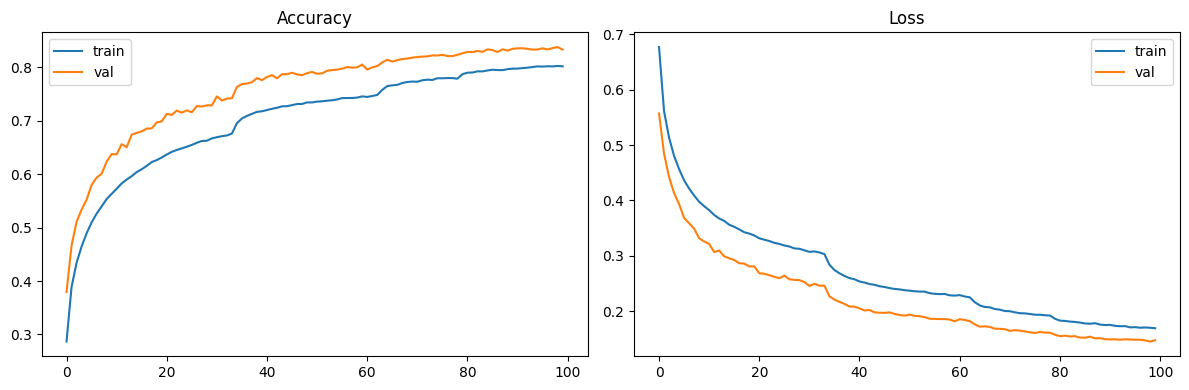

1054/1054 [==============================] - 19s 17ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.67      0.75      6744
           1       0.84      0.90      0.87      6744
           2       0.72      0.70      0.71      6744
           3       0.91      0.99      0.95      6744
           4       0.84      0.91      0.87      6744

    accuracy                           0.83     33720
   macro avg       0.83      0.83      0.83     33720
weighted avg       0.83      0.83      0.83     33720

Confusion Matrix:
[[4504  384 1459  134  263]
 [  94 6052  181   91  326]
 [ 607  526 4697  349  565]
 [   3   11   15 6690   25]
 [  34  270  180  117 6143]]

🧠 Cohen Kappa Score: 0.7911


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp08pchqge\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp08pchqge\assets



⏱️ Total training time: 402.66 minutes


In [7]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
import pywt
from scipy.stats import skew, kurtosis  # Added for skewness and kurtosis

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_FS = 256
TARGET_FS = 34.3
EPOCH_SAMPLES = 1024
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_FS / EPOCH_SAMPLES)
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR
DWT_LEVELS = 4
WAVELET = 'db4'

# --- Preprocessing functions ---
def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    nyq = 0.5 * fs
    wp = cutoff / nyq
    b, a = cheby2(order, rs, wp, btype='low', analog=False)
    filtered = filtfilt(b, a, signal)
    return filtered

def poly_detrend(signal, degree=10):
    x = np.arange(len(signal))
    coefs = Polynomial.fit(x, signal, degree).convert().coef
    trend = np.polyval(coefs[::-1], x)
    detrended = signal - trend
    return detrended

def min_max_norm(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    if max_val - min_val == 0:
        return signal * 0
    return (signal - min_val) / (max_val - min_val)

def extract_dwt_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    features = []
    for c in coeffs:
        features.extend([
            np.mean(c),              # Mean
            np.std(c),               # Standard deviation
            np.sum(c**2),            # Energy
            skew(c, bias=False),     # Skewness
            kurtosis(c, bias=False)  # Kurtosis
        ])
    return np.array(features)

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_FS, target_fs=TARGET_FS,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
    detrended = poly_detrend(filtered)
    normalized = min_max_norm(detrended)
    up = int(target_fs * 1000)
    down = int(orig_fs * 1000)
    gcd = np.gcd(up, down)
    up //= gcd
    down //= gcd
    resampled = resample_poly(normalized, up, down)
    total_samples = epoch_samples * total_epochs
    if len(resampled) > total_samples:
        resampled = resampled[:total_samples]
    elif len(resampled) < total_samples:
        pad_len = total_samples - len(resampled)
        resampled = np.pad(resampled, (0, pad_len), 'constant')
    epochs = resampled.reshape(total_epochs, epoch_samples)
    mask = np.array([0 if np.sum(e) == 0 else 1 for e in epochs])
    dwt_features = np.array([extract_dwt_features(epoch) for epoch in epochs])
    return epochs, dwt_features, mask

# --- Load raw data and preprocess ---
folder_path = r"D:\abhishek_extracted\plm"
mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]

X_epochs_list = []
X_dwt_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    mat = scipy.io.loadmat(file)
    raw_signal = mat['ppg_signals'].flatten()
    sleep_labels = mat['sleep_stages'].flatten()
    epochs, dwt_features, mask = preprocess_ppg_signal(raw_signal)
    if len(sleep_labels) > epochs.shape[0]:
        sleep_labels = sleep_labels[:epochs.shape[0]]
    elif len(sleep_labels) < epochs.shape[0]:
        pad_len = epochs.shape[0] - len(sleep_labels)
        sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)
    X_epochs_list.append(epochs)
    X_dwt_list.append(dwt_features)
    y_epochs_list.append(sleep_labels)
    mask_list.append(mask)

X_all = np.vstack(X_epochs_list)
X_dwt_all = np.vstack(X_dwt_list)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, DWT features per epoch: {X_dwt_all.shape[1]}")

# Save preprocessed data
np.save("ppg_epochs.npy", X_all)
np.save("dwt_features.npy", X_dwt_all)
np.save("sleep_labels.npy", y_all)
np.save("epoch_mask.npy", mask_all)

# --- Filter out zero-padded epochs ---
valid_idx = y_all != -1
valid_idx = valid_idx & (mask_all == 1)
X_all = X_all[valid_idx]
X_dwt_all = X_dwt_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")

# --- Print class distribution before augmentation ---
print("\nClass Distribution Before Augmentation:")
unique, counts = np.unique(y_all, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_all)*100:.2f}%)")

# --- Data Augmentation ---
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

# Augment all classes, lighter for majority classes
np.random.seed(42)
augmented_ppg = []
augmented_dwt = []
augmented_labels = []
majority_classes = [0, 2]  # Stage 0 and Stage 2

for ppg, dwt, label in zip(X_all, X_dwt_all, y_all):
    augmented_ppg.append(ppg)
    augmented_dwt.append(dwt)
    augmented_labels.append(label)
    if label in majority_classes:
        # Lighter augmentation for Classes 0 and 2
        if np.random.rand() < 0.3:  # Lower probability
            aug_ppg = jitter(ppg, sigma=0.005)  # Smaller sigma
            aug_dwt = jitter(dwt, sigma=0.002)
            augmented_ppg.append(aug_ppg)
            augmented_dwt.append(aug_dwt)
            augmented_labels.append(label)
        if np.random.rand() < 0.3:
            aug_ppg = scaling(ppg, sigma=0.05)
            aug_dwt = scaling(dwt, sigma=0.02)
            augmented_ppg.append(aug_ppg)
            augmented_dwt.append(aug_dwt)
            augmented_labels.append(label)
    else:
        # Stronger augmentation for Classes 1, 3, 4
        if np.random.rand() < 0.5:
            aug_ppg = jitter(ppg)
            aug_dwt = jitter(dwt, sigma=0.005)
            augmented_ppg.append(aug_ppg)
            augmented_dwt.append(aug_dwt)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = magnitude_warp(ppg)
            aug_dwt = dwt  # No warping for DWT
            augmented_ppg.append(aug_ppg)
            augmented_dwt.append(aug_dwt)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = scaling(ppg)
            aug_dwt = scaling(dwt, sigma=0.05)
            augmented_ppg.append(aug_ppg)
            augmented_dwt.append(aug_dwt)
            augmented_labels.append(label)

X_aug = np.array(augmented_ppg)
X_dwt_aug = np.array(augmented_dwt)
y_aug = np.array(augmented_labels)

# --- Print class distribution after augmentation ---
print("\nClass Distribution After Augmentation:")
unique, counts = np.unique(y_aug, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_aug)*100:.2f}%)")

# --- Standardization ---
scaler_ppg = StandardScaler()
X_scaled = scaler_ppg.fit_transform(X_aug)
scaler_dwt = StandardScaler()
X_dwt_scaled = scaler_dwt.fit_transform(X_dwt_aug)

# --- Handle Class Imbalance with SMOTE ---
X_combined = np.concatenate([X_scaled, X_dwt_scaled], axis=1)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_combined, y_aug)

# --- Print class distribution after SMOTE ---
print("\nClass Distribution After SMOTE:")
unique, counts = np.unique(y_res, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_res)*100:.2f}%)")

# Split back into PPG and DWT
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_dwt = X_res[:, X_scaled.shape[1]:]

# --- Class weights ---
class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# --- Train-test split ---
X_train_ppg, X_test_ppg, X_train_dwt, X_test_dwt, y_train, y_test = train_test_split(
    X_res_ppg, X_res_dwt, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# Expand dims for CNN input
X_train_ppg = X_train_ppg[..., np.newaxis]
X_test_ppg = X_test_ppg[..., np.newaxis]

# One-hot encoding
num_classes = 5
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# --- Focal loss ---
def focal_loss(gamma=1.5, alpha=[0.3, 0.7, 0.4, 1.0, 0.7]):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, dwt_shape):
    reg = l2(1e-4)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation="relu", kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation="sigmoid", kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)
    dwt_input = Input(shape=dwt_shape, name='dwt_input')
    d = GaussianNoise(0.02)(dwt_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    dwt_out = d
    combined = Concatenate()([ppg_out, dwt_out])
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=[ppg_input, dwt_input], outputs=outputs)

# --- Compile & train ---
model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_dwt.shape[1],))
model.compile(optimizer=Adam(2e-4),
              loss=focal_loss(gamma=1.5, alpha=[0.3, 0.7, 0.4, 1.0, 0.7]),
              metrics=['accuracy'])

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_dwt.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

history = model.fit([X_train_ppg, X_train_dwt], y_train_cat,
                    validation_data=([X_test_ppg, X_test_dwt], y_test_cat),
                    epochs=100, batch_size=32, class_weight=class_weight_dict,
                    callbacks=callbacks, verbose=1)

end_time = time.time()

# --- Plot training curves ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- Evaluation ---
y_pred = model.predict([X_test_ppg, X_test_dwt])
y_pred_cls = np.argmax(y_pred, axis=1)
y_true_cls = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_cls, y_pred_cls))

cm = confusion_matrix(y_true_cls, y_pred_cls)
print("Confusion Matrix:")
print(cm)

kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")

# --- Save model ---
model.save("cnn_dwt_rvfl_light_model.keras")

# --- Export TFLite ---
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("cnn_dwt_rvfl_light_model.tflite", "wb") as f:
    f.write(tflite_model)

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

In [8]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")



✅ Overall Test Accuracy: 0.8329


In [9]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Macro F1 Score:", f1_score(y_true_cls, y_pred_cls, average='macro'))
print("Weighted F1 Score:", f1_score(y_true_cls, y_pred_cls, average='weighted'))
print("Macro Precision:", precision_score(y_true_cls, y_pred_cls, average='macro'))
print("Macro Recall:", recall_score(y_true_cls, y_pred_cls, average='macro'))


Macro F1 Score: 0.829044292436729
Weighted F1 Score: 0.829044292436729
Macro Precision: 0.8318428811500842
Macro Recall: 0.8329181494661922


In [10]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
print(f"📉 Final Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")



📈 Final Accuracy: Train = 0.8016, Val = 0.8329
📉 Final Loss: Train = 0.1691, Val = 0.1475


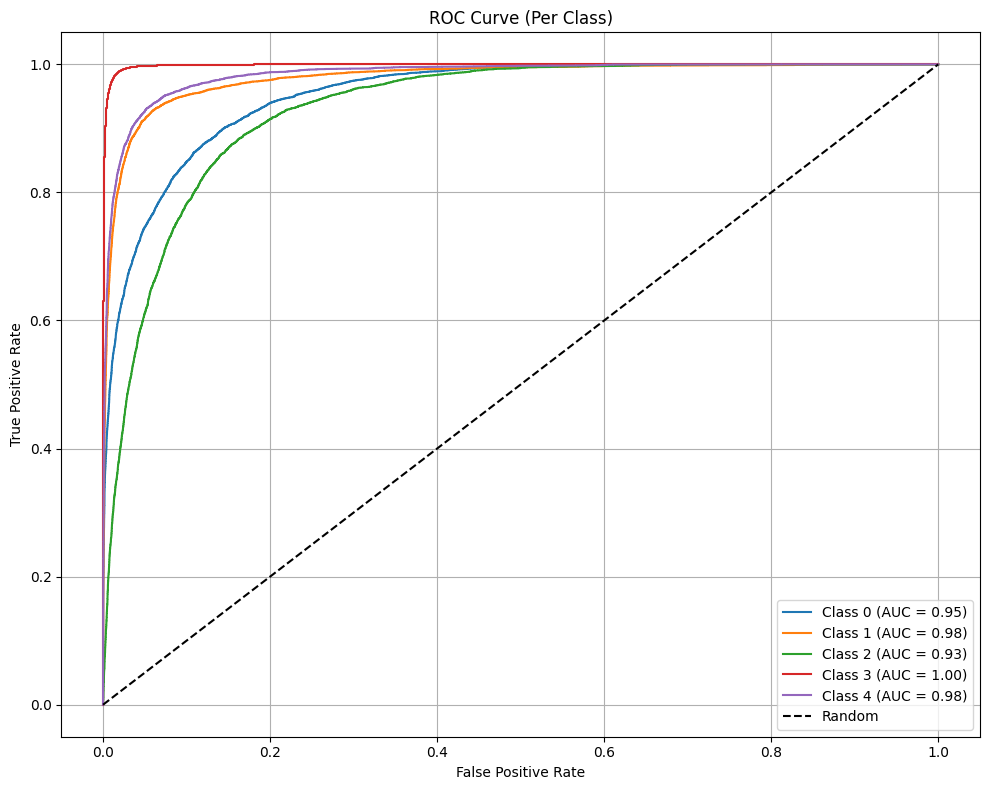

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure y_test is binarized
n_classes = 5
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


MSRFuseNet - Preprocessing - DWT(5 Features) - PLM - 39 - (SKEWNESS AND KURTOSIS) - HJORTH PARAMETERS

✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, Features per epoch: 28
Valid epochs after masking: 44857

Class Distribution Before Augmentation:
Class 0: 20959 samples (46.72%)
Class 1: 3768 samples (8.40%)
Class 2: 14564 samples (32.47%)
Class 3: 1784 samples (3.98%)
Class 4: 3782 samples (8.43%)

Class Distribution After Augmentation:
Class 0: 33442 samples (41.73%)
Class 1: 9401 samples (11.73%)
Class 2: 23409 samples (29.21%)
Class 3: 4426 samples (5.52%)
Class 4: 9453 samples (11.80%)


C:\Users\DST\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Class Distribution After SMOTE:
Class 0: 33442 samples (20.00%)
Class 1: 33442 samples (20.00%)
Class 2: 33442 samples (20.00%)
Class 3: 33442 samples (20.00%)
Class 4: 33442 samples (20.00%)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 1024, 1)]    0           []                               
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 1024, 1)     0           ['ppg_input[0][0]']              
                                                                                                  
 separable_conv1d (SeparableCon  (None, 1024, 32)    79          ['gaussian_noise[0][0]']         
 v1D)                                                                                             


                                                                                                  
 average_pooling1d (AveragePool  (None, 256, 32)     0           ['max_pooling1d_1[0][0]']        
 ing1D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 256, 32)     128         ['separable_conv1d_8[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 32)      0           ['max_pooling1d_1[0][0]',        
                                                                  'average_pooling1d[0][0]']      
                                                                                                  
 add_1 (Ad

 dense_5 (Dense)                (None, 32)           2080        ['dropout[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32)          128         ['dense_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 concatenate_1 (Concatenate)    (None, 8224)         0           ['flatten[0][0]',                
                                                                  'batch_normalization_14[0][0]'] 
                                                                                                  
 dense_6 (

4181/4181 [==============================] - 350s 84ms/step - loss: 0.1862 - accuracy: 0.7906 - val_loss: 0.1620 - val_accuracy: 0.8247 - lr: 5.0000e-05
Epoch 84/100
4181/4181 [==============================] - 349s 84ms/step - loss: 0.1860 - accuracy: 0.7903 - val_loss: 0.1621 - val_accuracy: 0.8238 - lr: 5.0000e-05
Epoch 85/100
4181/4181 [==============================] - 349s 83ms/step - loss: 0.1848 - accuracy: 0.7911 - val_loss: 0.1594 - val_accuracy: 0.8283 - lr: 5.0000e-05
Epoch 86/100
4181/4181 [==============================] - 347s 83ms/step - loss: 0.1843 - accuracy: 0.7920 - val_loss: 0.1592 - val_accuracy: 0.8273 - lr: 5.0000e-05
Epoch 87/100
4181/4181 [==============================] - 349s 84ms/step - loss: 0.1840 - accuracy: 0.7913 - val_loss: 0.1599 - val_accuracy: 0.8258 - lr: 5.0000e-05
Epoch 88/100
4181/4181 [==============================] - 348s 83ms/step - loss: 0.1827 - accuracy: 0.7932 - val_loss: 0.1593 - val_accuracy: 0.8264 - lr: 5.0000e-05
Epoch 89/100
4181

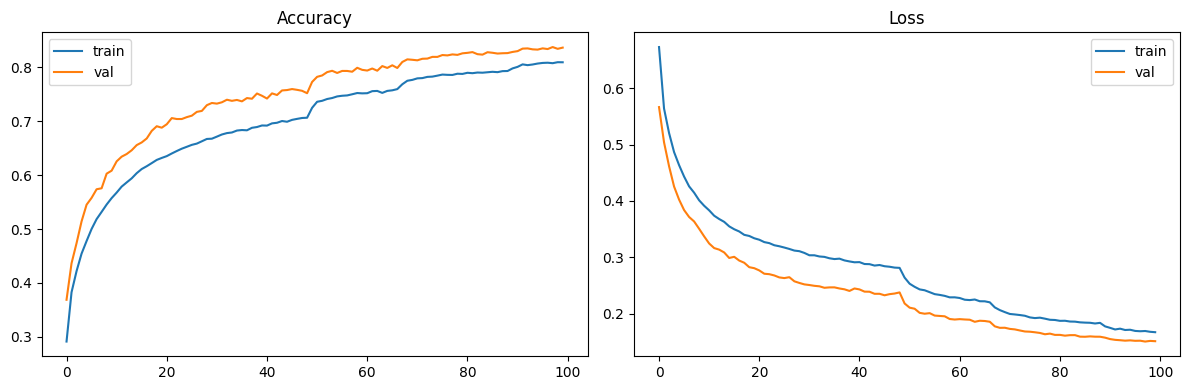

1046/1046 [==============================] - 19s 17ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.69      0.76      6689
           1       0.84      0.90      0.87      6688
           2       0.73      0.70      0.71      6688
           3       0.92      0.99      0.95      6689
           4       0.84      0.91      0.88      6688

    accuracy                           0.84     33442
   macro avg       0.84      0.84      0.83     33442
weighted avg       0.84      0.84      0.83     33442

Confusion Matrix:
[[4588  364 1357  106  274]
 [ 112 5998  200   90  288]
 [ 674  486 4692  304  532]
 [   3   13   20 6632   21]
 [  39  262  197  114 6076]]

🧠 Cohen Kappa Score: 0.7961


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpice30cz5\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpice30cz5\assets



⏱️ Total training time: 565.99 minutes


In [1]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
import pywt
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_FS = 256
TARGET_FS = 34.3
EPOCH_SAMPLES = 1024
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_FS / EPOCH_SAMPLES)
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR
DWT_LEVELS = 4
WAVELET = 'db4'

# --- Hjorth Parameters ---
def hjorth_parameters(signal):
    activity = np.var(signal)
    diff = np.diff(signal)
    mobility = np.std(diff) / (np.std(signal) + 1e-10)
    diff2 = np.diff(diff)
    complexity = (np.std(diff2) / (np.std(diff) + 1e-10)) / (mobility + 1e-10)
    return np.array([activity, mobility, complexity])

# --- Preprocessing functions ---
def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    nyq = 0.5 * fs
    wp = cutoff / nyq
    b, a = cheby2(order, rs, wp, btype='low', analog=False)
    filtered = filtfilt(b, a, signal)
    return filtered

def poly_detrend(signal, degree=10):
    x = np.arange(len(signal))
    coefs = Polynomial.fit(x, signal, degree).convert().coef
    trend = np.polyval(coefs[::-1], x)
    detrended = signal - trend
    return detrended

def min_max_norm(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    if max_val - min_val == 0:
        return signal * 0
    return (signal - min_val) / (max_val - min_val)

def extract_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    dwt_features = []
    for c in coeffs:
        dwt_features.extend([
            np.mean(c),
            np.std(c),
            np.sum(c**2),
            skew(c, bias=False),
            kurtosis(c, bias=False)
        ])
    hjorth = hjorth_parameters(signal)
    return np.concatenate([dwt_features, hjorth])

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_FS, target_fs=TARGET_FS,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
    detrended = poly_detrend(filtered)
    normalized = min_max_norm(detrended)
    up = int(target_fs * 1000)
    down = int(orig_fs * 1000)
    gcd = np.gcd(up, down)
    up //= gcd
    down //= gcd
    resampled = resample_poly(normalized, up, down)
    total_samples = epoch_samples * total_epochs
    if len(resampled) > total_samples:
        resampled = resampled[:total_samples]
    elif len(resampled) < total_samples:
        pad_len = total_samples - len(resampled)
        resampled = np.pad(resampled, (0, pad_len), 'constant')
    epochs = resampled.reshape(total_epochs, epoch_samples)
    mask = np.array([0 if np.sum(e) == 0 else 1 for e in epochs])
    features = np.array([extract_features(epoch) for epoch in epochs])
    return epochs, features, mask

# --- Load raw data and preprocess ---
folder_path = r"D:\abhishek_extracted\plm"
mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]

X_epochs_list = []
X_features_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    mat = scipy.io.loadmat(file)
    raw_signal = mat['ppg_signals'].flatten()
    sleep_labels = mat['sleep_stages'].flatten()
    epochs, features, mask = preprocess_ppg_signal(raw_signal)
    if len(sleep_labels) > epochs.shape[0]:
        sleep_labels = sleep_labels[:epochs.shape[0]]
    elif len(sleep_labels) < epochs.shape[0]:
        pad_len = epochs.shape[0] - len(sleep_labels)
        sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)
    X_epochs_list.append(epochs)
    X_features_list.append(features)
    y_epochs_list.append(sleep_labels)
    mask_list.append(mask)

X_all = np.vstack(X_epochs_list)
X_features_all = np.vstack(X_features_list)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, Features per epoch: {X_features_all.shape[1]}")

# Save preprocessed data
np.save("ppg_epochs.npy", X_all)
np.save("features.npy", X_features_all)
np.save("sleep_labels.npy", y_all)
np.save("epoch_mask.npy", mask_all)

# --- Filter out zero-padded epochs ---
valid_idx = y_all != -1
valid_idx = valid_idx & (mask_all == 1)
X_all = X_all[valid_idx]
X_features_all = X_features_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")

# --- Print class distribution before augmentation ---
print("\nClass Distribution Before Augmentation:")
unique, counts = np.unique(y_all, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_all)*100:.2f}%)")

# --- Data Augmentation ---
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

np.random.seed(42)
augmented_ppg = []
augmented_features = []
augmented_labels = []
majority_classes = [0, 2]

for ppg, feat, label in zip(X_all, X_features_all, y_all):
    augmented_ppg.append(ppg)
    augmented_features.append(feat)
    augmented_labels.append(label)
    if label in majority_classes:
        if np.random.rand() < 0.3:
            aug_ppg = jitter(ppg, sigma=0.005)
            aug_feat = jitter(feat, sigma=0.002)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.3:
            aug_ppg = scaling(ppg, sigma=0.05)
            aug_feat = scaling(feat, sigma=0.02)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
    else:
        if np.random.rand() < 0.5:
            aug_ppg = jitter(ppg)
            aug_feat = jitter(feat, sigma=0.005)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = magnitude_warp(ppg)
            aug_feat = feat
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = scaling(ppg)
            aug_feat = scaling(feat, sigma=0.05)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)

X_aug = np.array(augmented_ppg)
X_features_aug = np.array(augmented_features)
y_aug = np.array(augmented_labels)

# --- Print class distribution after augmentation ---
print("\nClass Distribution After Augmentation:")
unique, counts = np.unique(y_aug, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_aug)*100:.2f}%)")

# --- Standardization ---
scaler_ppg = StandardScaler()
X_scaled = scaler_ppg.fit_transform(X_aug)
scaler_features = StandardScaler()
X_features_scaled = scaler_features.fit_transform(X_features_aug)

# --- Handle Class Imbalance with SMOTE ---
X_combined = np.concatenate([X_scaled, X_features_scaled], axis=1)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_combined, y_aug)

# --- Print class distribution after SMOTE ---
print("\nClass Distribution After SMOTE:")
unique, counts = np.unique(y_res, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_res)*100:.2f}%)")

# Split back into PPG and features
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_features = X_res[:, X_scaled.shape[1]:]

# --- Class weights ---
class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# --- Train-test split ---
X_train_ppg, X_test_ppg, X_train_features, X_test_features, y_train, y_test = train_test_split(
    X_res_ppg, X_res_features, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# Expand dims for CNN input
X_train_ppg = X_train_ppg[..., np.newaxis]
X_test_ppg = X_test_ppg[..., np.newaxis]

# One-hot encoding
num_classes = 5
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# --- Focal loss ---
def focal_loss(gamma=1.5, alpha=[0.3, 0.7, 0.4, 1.0, 0.7]):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, features_shape):
    reg = l2(1e-4)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation="relu", kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation="sigmoid", kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)
    features_input = Input(shape=features_shape, name='features_input')
    d = GaussianNoise(0.02)(features_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    features_out = d
    combined = Concatenate()([ppg_out, features_out])
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=[ppg_input, features_input], outputs=outputs)

# --- Compile & train ---
model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_features.shape[1],))
model.compile(optimizer=Adam(2e-4),
              loss=focal_loss(gamma=1.5, alpha=[0.3, 0.7, 0.4, 1.0, 0.7]),
              metrics=['accuracy'])

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_features.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

history = model.fit([X_train_ppg, X_train_features], y_train_cat,
                    validation_data=([X_test_ppg, X_test_features], y_test_cat),
                    epochs=100, batch_size=32, class_weight=class_weight_dict,
                    callbacks=callbacks, verbose=1)

end_time = time.time()

# --- Plot training curves ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- Evaluation ---
y_pred = model.predict([X_test_ppg, X_test_features])
y_pred_cls = np.argmax(y_pred, axis=1)
y_true_cls = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_cls, y_pred_cls))

cm = confusion_matrix(y_true_cls, y_pred_cls)
print("Confusion Matrix:")
print(cm)

kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")

# --- Save model ---
model.save("cnn_features_rvfl_light_model.keras")

# --- Export TFLite ---
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("cnn_features_rvfl_light_model.tflite", "wb") as f:
    f.write(tflite_model)

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

In [3]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")



✅ Overall Test Accuracy: 0.8369


In [4]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Macro F1 Score:", f1_score(y_true_cls, y_pred_cls, average='macro'))
print("Weighted F1 Score:", f1_score(y_true_cls, y_pred_cls, average='weighted'))
print("Macro Precision:", precision_score(y_true_cls, y_pred_cls, average='macro'))
print("Macro Recall:", recall_score(y_true_cls, y_pred_cls, average='macro'))

Macro F1 Score: 0.8334854635779683
Weighted F1 Score: 0.833486746719175
Macro Precision: 0.8350062115112525
Macro Recall: 0.8368517529672724


In [5]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
print(f"📉 Final Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")


📈 Final Accuracy: Train = 0.8097, Val = 0.8369
📉 Final Loss: Train = 0.1673, Val = 0.1513


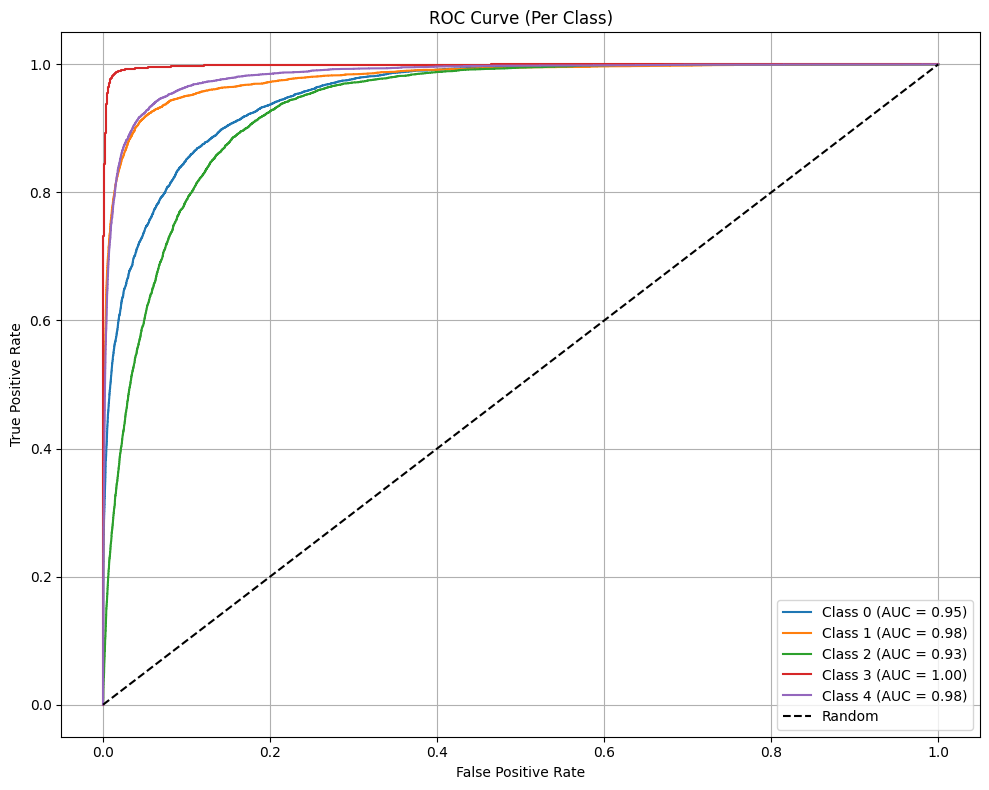

In [6]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure y_test is binarized
n_classes = 5
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

MSRFuseNet - Preprocessing - DWT(5 Features) - PLM - 39 - (SKEWNESS AND KURTOSIS) - HJORTH PARAMETERS - 4 CLASS (REDUCED CLASS GROUPINGS)

✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, Features per epoch: 28
Valid epochs after masking: 44857

Class Distribution Before Augmentation:
Class 0: 20959 samples (46.72%)
Class 1: 18332 samples (40.87%)
Class 2: 1784 samples (3.98%)
Class 3: 3782 samples (8.43%)

Class Distribution After Augmentation:
Class 0: 33628 samples (43.79%)
Class 1: 29334 samples (38.20%)
Class 2: 4461 samples (5.81%)
Class 3: 9364 samples (12.19%)

Class Distribution After SMOTE:
Class 0: 33628 samples (25.00%)
Class 1: 33628 samples (25.00%)
Class 2: 33628 samples (25.00%)
Class 3: 33628 samples (25.00%)

Dynamic Focal Loss Alpha: [1.0, 1.0, 1.0, 1.0]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 1024, 1)]    0         

                                                                                                  
 max_pooling1d_1 (MaxPooling1D)  (None, 256, 32)     0           ['spatial_dropout1d_1[0][0]']    
                                                                                                  
 separable_conv1d_8 (SeparableC  (None, 256, 32)     1280        ['max_pooling1d_1[0][0]']        
 onv1D)                                                                                           
                                                                                                  
 average_pooling1d (AveragePool  (None, 256, 32)     0           ['max_pooling1d_1[0][0]']        
 ing1D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 256, 32)     128         ['separable_conv1d_8[0][0]']     
 rmalizati

 dropout (Dropout)              (None, 64)           0           ['batch_normalization_13[0][0]'] 
                                                                                                  
 layer_normalization_2 (LayerNo  (None, 128, 64)     128         ['add_2[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_5 (Dense)                (None, 32)           2080        ['dropout[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32)          128         ['dense_5[0][0]']                
 ormalizat

3363/3363 [==============================] - 273s 81ms/step - loss: 0.2243 - accuracy: 0.8448 - val_loss: 0.2668 - val_accuracy: 0.8237 - lr: 3.1250e-06
Epoch 81/100
3363/3363 [==============================] - 270s 80ms/step - loss: 0.2251 - accuracy: 0.8433 - val_loss: 0.2700 - val_accuracy: 0.8208 - lr: 3.1250e-06
Epoch 82/100
3363/3363 [==============================] - 273s 81ms/step - loss: 0.2235 - accuracy: 0.8444 - val_loss: 0.2692 - val_accuracy: 0.8235 - lr: 1.5625e-06
Epoch 83/100
3363/3363 [==============================] - 270s 80ms/step - loss: 0.2228 - accuracy: 0.8447 - val_loss: 0.2686 - val_accuracy: 0.8237 - lr: 1.5625e-06
Epoch 84/100
3363/3363 [==============================] - 272s 81ms/step - loss: 0.2231 - accuracy: 0.8443 - val_loss: 0.2657 - val_accuracy: 0.8250 - lr: 1.5625e-06
Epoch 85/100
3363/3363 [==============================] - 272s 81ms/step - loss: 0.2245 - accuracy: 0.8440 - val_loss: 0.2657 - val_accuracy: 0.8238 - lr: 7.8125e-07
Epoch 86/100
3363

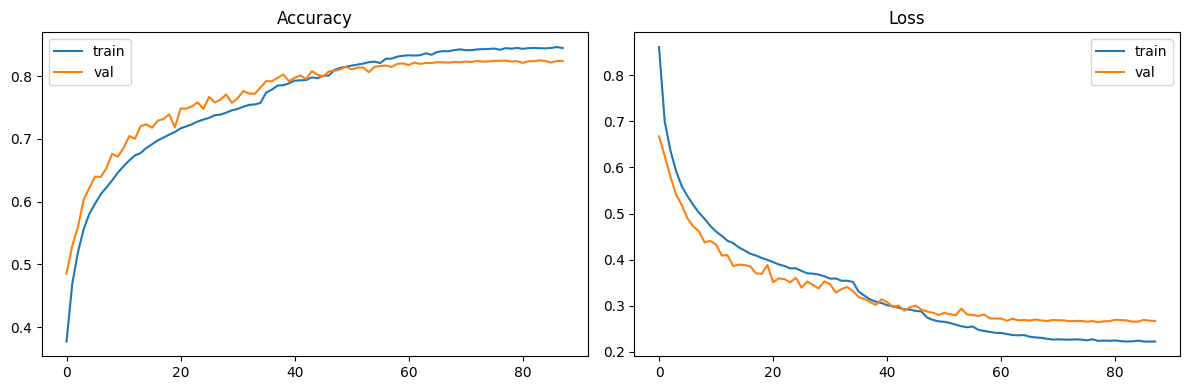

841/841 [==============================] - 17s 20ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.72      0.76      6726
           1       0.72      0.67      0.69      6725
           2       0.93      0.98      0.95      6726
           3       0.84      0.93      0.88      6726

    accuracy                           0.82     26903
   macro avg       0.82      0.82      0.82     26903
weighted avg       0.82      0.82      0.82     26903

Confusion Matrix:
[[4870 1499   80  277]
 [1206 4506  248  765]
 [  18   40 6565  103]
 [  69  243  172 6242]]

🧠 Cohen Kappa Score: 0.7661


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp41jqmcsr\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp41jqmcsr\assets



⏱️ Total training time: 402.66 minutes


In [12]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import skew, kurtosis
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set global random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_SF = 256
TARGET_SF = 34.3
EPOCH_SAMPLES = 1024
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_SF / EPOCH_SAMPLES)
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR
DWT_LEVELS = 4
WAVELET = 'db4'
NUM_CLASSES = 4

# --- Hjorth Parameters ---
def hjorth_parameters(signal):
    try:
        activity = np.var(signal)
        diff = np.diff(signal)
        mobility = np.std(diff) / (np.std(signal) + 1e-10)
        diff2 = np.diff(diff)
        complexity = (np.std(diff2) / (np.std(diff) + 1e-10)) / (mobility + 1e-10)
        return np.array([activity, mobility, complexity])
    except Exception as e:
        print(f"Error in Hjorth parameters: {e}")
        return np.zeros(3)

# --- Preprocessing functions ---
def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    try:
        nyq = 0.5 * fs
        wp = cutoff / nyq
        b, a = cheby2(order, rs, wp, btype='low', analog=False)
        filtered = filtfilt(b, a, signal)
        return filtered
    except Exception as e:
        print(f"Error in cheby2 filter: {e}")
        return signal

def poly_detrend(signal, degree=10):
    try:
        x = np.arange(len(signal))
        coefs = Polynomial.fit(x, signal, degree).convert().coef
        trend = np.polyval(coefs[::-1], x)
        detrended = signal - trend
        return detrended
    except Exception as e:
        print(f"Error in detrending: {e}")
        return signal

def min_max_norm(signal):
    try:
        min_val = np.min(signal)
        max_val = np.max(signal)
        if max_val - min_val == 0:
            return signal * 0
        return (signal - min_val) / (max_val - min_val)
    except Exception as e:
        print(f"Error in normalization: {e}")
        return signal

def extract_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    try:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        dwt_features = []
        for c in coeffs:
            dwt_features.extend([
                np.mean(c),
                np.std(c),
                np.sum(c**2),
                skew(c, bias=False) if np.std(c) > 1e-10 else 0.0,
                kurtosis(c, bias=False) if np.std(c) > 1e-10 else 0.0
            ])
        hjorth = hjorth_parameters(signal)
        features = np.concatenate([dwt_features, hjorth])
        return np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    except Exception as e:
        print(f"Error in feature extraction: {e}")
        return np.zeros(28)

def map_to_4_classes(y):
    mapping = {
        0: 0,  # Wake
        1: 1,  # N1 -> Light Sleep
        2: 1,  # N2 -> Light Sleep
        3: 2,  # N3 -> Deep Sleep
        4: 3   # REM
    }
    return np.vectorize(mapping.get)(y)

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_SF, target_fs=TARGET_SF,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    try:
        filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
        detrended = poly_detrend(filtered)
        normalized = min_max_norm(detrended)
        up = int(target_fs * 1000)
        down = int(orig_fs * 1000)
        gcd = np.gcd(up, down)
        up //= gcd
        down //= gcd
        resampled = resample_poly(normalized, up, down)
        total_samples = epoch_samples * total_epochs
        if len(resampled) > total_samples:
            resampled = resampled[:total_samples]
        elif len(resampled) < total_samples:
            pad_len = total_samples - len(resampled)
            resampled = np.pad(resampled, (0, pad_len), 'constant')
        epochs = resampled.reshape(total_epochs, epoch_samples)
        mask = np.array([0 if np.sum(np.abs(e)) < 1e-10 else 1 for e in epochs])
        features = np.array([extract_features(epoch) for epoch in epochs])
        return epochs, features, mask
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return np.zeros((total_epochs, epoch_samples)), np.zeros((total_epochs, 28)), np.zeros(total_epochs)

# --- Load raw data and preprocess ---
folder_path = r"D:\abhishek_extracted\plm"
try:
    mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]
    if not mat_files:
        raise FileNotFoundError(f"No .mat files found in {folder_path}")
except Exception as e:
    print(f"Error loading files: {e}")
    exit(1)

X_epochs_list = []
X_features_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    try:
        mat = scipy.io.loadmat(file)
        raw_signal = mat['ppg_signals'].flatten()
        sleep_labels = mat['sleep_stages'].flatten()
        sleep_labels = map_to_4_classes(sleep_labels)
        epochs, features, mask = preprocess_ppg_signal(raw_signal)
        if len(sleep_labels) > epochs.shape[0]:
            sleep_labels = sleep_labels[:epochs.shape[0]]
        elif len(sleep_labels) < epochs.shape[0]:
            pad_len = epochs.shape[0] - len(sleep_labels)
            sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)
        X_epochs_list.append(epochs)
        X_features_list.append(features)
        y_epochs_list.append(sleep_labels)
        mask_list.append(mask)
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        continue

if not X_epochs_list:
    print("No valid data loaded. Exiting.")
    exit(1)

X_all = np.vstack(X_epochs_list)
X_features_all = np.vstack(X_features_list)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, Features per epoch: {X_features_all.shape[1]}")

# Save preprocessed data
try:
    np.save("ppg_epochs.npy", X_all)
    np.save("features.npy", X_features_all)
    np.save("sleep_labels_4class.npy", y_all)
    np.save("epoch_mask.npy", mask_all)
except Exception as e:
    print(f"Error saving preprocessed data: {e}")

# --- Filter out invalid epochs ---
valid_idx = (y_all != -1) & (mask_all == 1)
X_all = X_all[valid_idx]
X_features_all = X_features_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")
if len(y_all) == 0:
    print("No valid epochs after masking. Exiting.")
    exit(1)

# --- Print class distribution before augmentation ---
print("\nClass Distribution Before Augmentation:")
unique, counts = np.unique(y_all, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_all)*100:.2f}%)")

# --- Data Augmentation ---
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

np.random.seed(42)
augmented_ppg = []
augmented_features = []
augmented_labels = []
majority_classes = [0, 1]  # Wake, Light Sleep

for ppg, feat, label in zip(X_all, X_features_all, y_all):
    augmented_ppg.append(ppg)
    augmented_features.append(feat)
    augmented_labels.append(label)
    if label in majority_classes:
        if np.random.rand() < 0.3:
            aug_ppg = jitter(ppg, sigma=0.005)
            aug_feat = jitter(feat, sigma=0.002)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.3:
            aug_ppg = scaling(ppg, sigma=0.05)
            aug_feat = scaling(feat, sigma=0.02)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
    else:
        if np.random.rand() < 0.5:
            aug_ppg = jitter(ppg)
            aug_feat = jitter(feat, sigma=0.005)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = magnitude_warp(ppg)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = scaling(ppg)
            aug_feat = scaling(feat, sigma=0.05)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)

X_aug = np.array(augmented_ppg)
X_features_aug = np.array(augmented_features)
y_aug = np.array(augmented_labels)

# --- Print class distribution after augmentation ---
print("\nClass Distribution After Augmentation:")
unique, counts = np.unique(y_aug, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_aug)*100:.2f}%)")

# --- Standardization ---
try:
    scaler_ppg = StandardScaler()
    X_scaled = scaler_ppg.fit_transform(X_aug)
    scaler_features = StandardScaler()
    X_features_scaled = scaler_features.fit_transform(X_features_aug)
except Exception as e:
    print(f"Error in standardization: {e}")
    exit(1)

# --- Validate data ---
if np.any(np.isnan(X_scaled)) or np.any(np.isinf(X_scaled)):
    raise ValueError("NaN or infinite values in X_scaled")
if np.any(np.isnan(X_features_scaled)) or np.any(np.isinf(X_features_scaled)):
    raise ValueError("NaN or infinite values in X_features_scaled")
if X_scaled.shape[0] != y_aug.shape[0] or X_features_scaled.shape[0] != y_aug.shape[0]:
    raise ValueError(f"Inconsistent sample sizes: X_scaled={X_scaled.shape[0]}, X_features_scaled={X_features_scaled.shape[0]}, y_aug={y_aug.shape[0]}")

# --- Handle Class Imbalance with SMOTE ---
try:
    X_combined = np.concatenate([X_scaled, X_features_scaled], axis=1)
    min_samples = 6  # SMOTE k_neighbors=5 requires at least 6 samples
    class_counts = np.bincount(y_aug.astype(int), minlength=NUM_CLASSES)
    if np.any(class_counts < min_samples):
        print("\nWarning: Some classes have too few samples for SMOTE. Adjusting k_neighbors.")
        k_neighbors = min(np.min(class_counts[class_counts > 0]) - 1, 5)
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors if k_neighbors > 0 else 1)
    else:
        smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_combined, y_aug)
except Exception as e:
    print(f"Error in SMOTE: {e}")
    exit(1)

# Split back into PPG and features
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_features = X_res[:, X_scaled.shape[1]:]

# --- Print class distribution after SMOTE ---
print("\nClass Distribution After SMOTE:")
unique, counts = np.unique(y_res, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_res)*100:.2f}%)")

# --- Class weights ---
try:
    class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
except Exception as e:
    print(f"Error computing class weights: {e}")
    exit(1)

# --- Train-test split ---
try:
    X_train_ppg, X_test_ppg, X_train_features, X_test_features, y_train, y_test = train_test_split(
        X_res_ppg, X_res_features, y_res, test_size=0.2, stratify=y_res, random_state=42
    )
except Exception as e:
    print(f"Error in train-test split: {e}")
    exit(1)

# Expand dims for CNN input
try:
    X_train_ppg = X_train_ppg[..., np.newaxis]
    X_test_ppg = X_test_ppg[..., np.newaxis]
except Exception as e:
    print(f"Error in expanding dimensions: {e}")
    exit(1)

# One-hot encoding
try:
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)
except Exception as e:
    print(f"Error in one-hot encoding: {e}")
    exit(1)

# --- Dynamic focal loss alpha ---
class_freq = np.bincount(y_res.astype(int), minlength=NUM_CLASSES)
alpha = 1.0 / (class_freq + 1e-10)  # Inverse frequency
alpha = alpha / np.sum(alpha) * NUM_CLASSES  # Normalize to sum to num_classes
print(f"\nDynamic Focal Loss Alpha: {alpha.tolist()}")

# --- Focal loss ---
def focal_loss(gamma=1.5, alpha=alpha):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, features_shape):
    reg = l2(1e-4)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation='relu', kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation='sigmoid', kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)
    features_input = Input(shape=features_shape, name='features_input')
    d = GaussianNoise(0.02)(features_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    features_out = d
    combined = Concatenate()([ppg_out, features_out])
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=[ppg_input, features_input], outputs=outputs)

# --- Compile & train ---
try:
    model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_features.shape[1],))
    model.compile(optimizer=Adam(2e-4),
                  loss=focal_loss(gamma=1.5),
                  metrics=['accuracy'])
except Exception as e:
    print(f"Error building/compiling model: {e}")
    exit(1)

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_features_4class.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

try:
    history = model.fit([X_train_ppg, X_train_features], y_train_cat,
                        validation_data=([X_test_ppg, X_test_features], y_test_cat),
                        epochs=100, batch_size=32, class_weight=class_weight_dict,
                        callbacks=callbacks, verbose=1)
except Exception as e:
    print(f"Error during training: {e}")
    exit(1)

end_time = time.time()

# --- Plot training curves ---
try:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error plotting curves: {e}")

# --- Evaluation ---
try:
    y_pred = model.predict([X_test_ppg, X_test_features])
    y_pred_cls = np.argmax(y_pred, axis=1)
    y_true_cls = np.argmax(y_test_cat, axis=1)
    print("\nClassification Report:")
    print(classification_report(y_true_cls, y_pred_cls))
    cm = confusion_matrix(y_true_cls, y_pred_cls)
    print("Confusion Matrix:")
    print(cm)
    kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
    print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")
except Exception as e:
    print(f"Error during evaluation: {e}")
    exit(1)

# --- Save model ---
try:
    model.save("cnn_features_rvfl_light_model_4class.keras")
except Exception as e:
    print(f"Error saving model: {e}")

# --- Export TFLite ---
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open("cnn_features_rvfl_light_model_4class.tflite", "wb") as f:
        f.write(tflite_model)
except Exception as e:
    print(f"Error exporting TFLite: {e}")

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

In [13]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")


✅ Overall Test Accuracy: 0.8246


In [14]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Macro F1 Score:", f1_score(y_true_cls, y_pred_cls, average='macro'))
print("Weighted F1 Score:", f1_score(y_true_cls, y_pred_cls, average='weighted'))
print("Macro Precision:", precision_score(y_true_cls, y_pred_cls, average='macro'))
print("Macro Recall:", recall_score(y_true_cls, y_pred_cls, average='macro'))


Macro F1 Score: 0.8212165170353125
Weighted F1 Score: 0.8212213000812938
Macro Precision: 0.8202572981543341
Macro Recall: 0.8245491390564497


In [15]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
print(f"📉 Final Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")


📈 Final Accuracy: Train = 0.8444, Val = 0.8238
📉 Final Loss: Train = 0.2228, Val = 0.2673


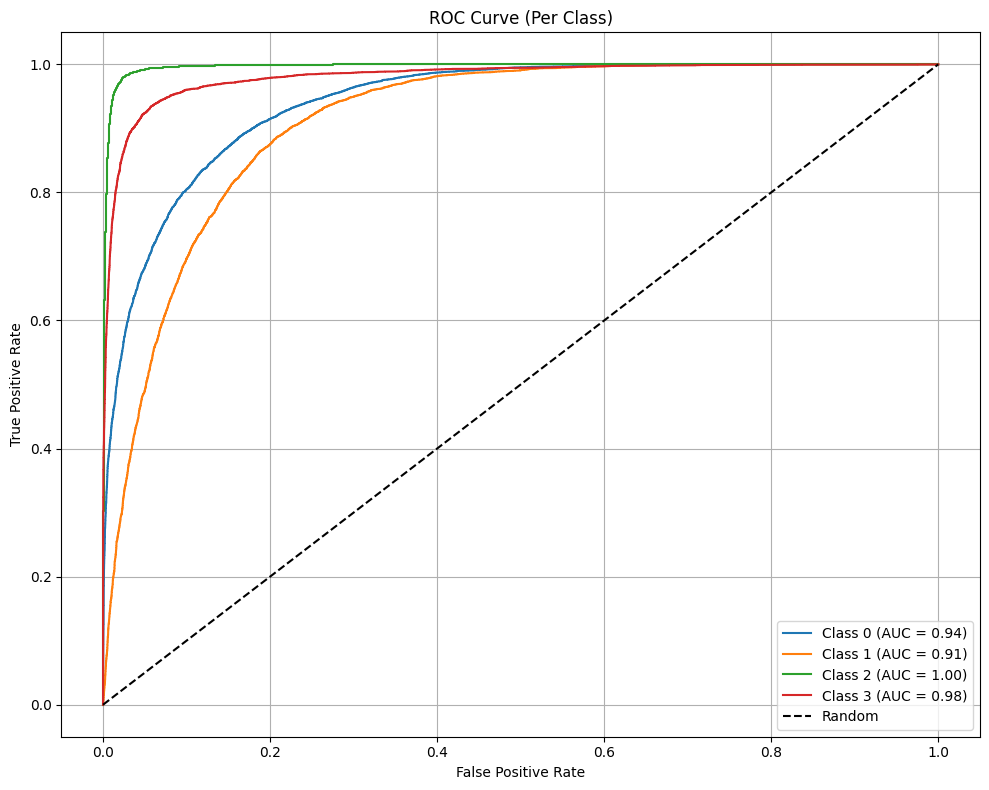

In [16]:

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure y_test is binarized
n_classes = 4
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, Features per epoch: 28
Valid epochs after masking: 44857

Class Distribution Before Augmentation:
Class 0: 20959 samples (46.72%)
Class 1: 18332 samples (40.87%)
Class 2: 1784 samples (3.98%)
Class 3: 3782 samples (8.43%)

Class Distribution After Augmentation:
Class 0: 33628 samples (43.79%)
Class 1: 29334 samples (38.20%)
Class 2: 4461 samples (5.81%)
Class 3: 9364 samples (12.19%)

Class Distribution After SMOTE:
Class 0: 33628 samples (25.00%)
Class 1: 33628 samples (25.00%)
Class 2: 33628 samples (25.00%)
Class 3: 33628 samples (25.00%)

Fixed Focal Loss Alpha: [0.1855, 0.2344, 2.4316, 1.1484]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 1024, 1)]    

                                                                                                  
 max_pooling1d_1 (MaxPooling1D)  (None, 256, 32)     0           ['spatial_dropout1d_1[0][0]']    
                                                                                                  
 separable_conv1d_8 (SeparableC  (None, 256, 32)     1280        ['max_pooling1d_1[0][0]']        
 onv1D)                                                                                           
                                                                                                  
 average_pooling1d (AveragePool  (None, 256, 32)     0           ['max_pooling1d_1[0][0]']        
 ing1D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 256, 32)     128         ['separable_conv1d_8[0][0]']     
 rmalizati

 dropout (Dropout)              (None, 64)           0           ['batch_normalization_13[0][0]'] 
                                                                                                  
 layer_normalization_2 (LayerNo  (None, 128, 64)     128         ['add_2[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_5 (Dense)                (None, 32)           2080        ['dropout[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32)          128         ['dense_5[0][0]']                
 ormalizat

3363/3363 [==============================] - 267s 79ms/step - loss: 0.1315 - accuracy: 0.7762 - val_loss: 0.1191 - val_accuracy: 0.7894 - lr: 1.2500e-05
Epoch 81/100
3363/3363 [==============================] - 268s 80ms/step - loss: 0.1322 - accuracy: 0.7775 - val_loss: 0.1189 - val_accuracy: 0.7861 - lr: 1.2500e-05
Epoch 82/100
3363/3363 [==============================] - 273s 81ms/step - loss: 0.1315 - accuracy: 0.7795 - val_loss: 0.1188 - val_accuracy: 0.7880 - lr: 6.2500e-06
Epoch 83/100
3363/3363 [==============================] - 274s 81ms/step - loss: 0.1304 - accuracy: 0.7800 - val_loss: 0.1188 - val_accuracy: 0.7843 - lr: 6.2500e-06
Epoch 84/100
3363/3363 [==============================] - 271s 81ms/step - loss: 0.1303 - accuracy: 0.7806 - val_loss: 0.1181 - val_accuracy: 0.7922 - lr: 6.2500e-06
Epoch 85/100
3363/3363 [==============================] - 275s 82ms/step - loss: 0.1298 - accuracy: 0.7785 - val_loss: 0.1181 - val_accuracy: 0.7898 - lr: 6.2500e-06
Epoch 86/100
3363

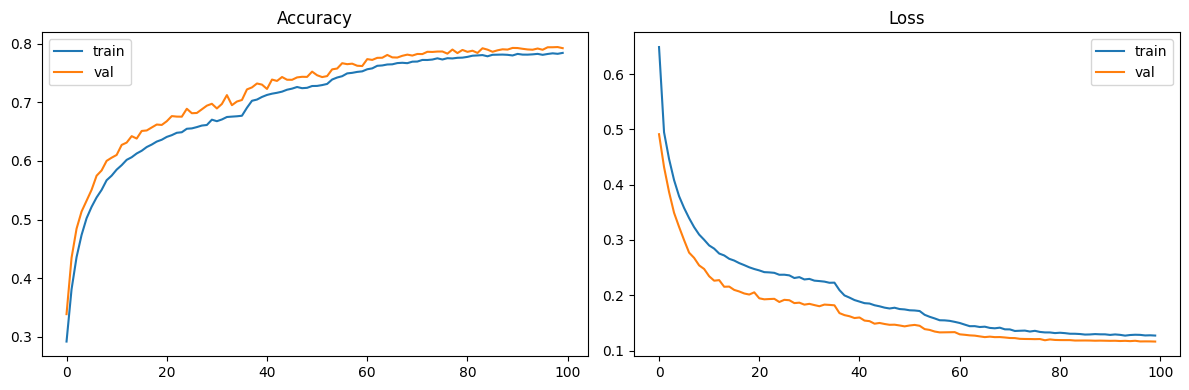

841/841 [==============================] - 14s 16ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.66      0.72      6726
           1       0.70      0.55      0.61      6725
           2       0.91      0.99      0.95      6726
           3       0.75      0.97      0.84      6726

    accuracy                           0.79     26903
   macro avg       0.79      0.79      0.78     26903
weighted avg       0.79      0.79      0.78     26903

Confusion Matrix:
[[4420 1518  164  624]
 [1037 3698  416 1574]
 [   1    4 6692   29]
 [  22   96  101 6507]]

🧠 Cohen Kappa Score: 0.7232


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp2a4_i1em\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp2a4_i1em\assets



⏱️ Total training time: 446.88 minutes


In [1]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import skew, kurtosis
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set global random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_SF = 256
TARGET_SF = 34.3
EPOCH_SAMPLES = 1024
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_SF / EPOCH_SAMPLES)
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR
DWT_LEVELS = 4
WAVELET = 'db4'
NUM_CLASSES = 4

# --- Hjorth Parameters ---
def hjorth_parameters(signal):
    try:
        activity = np.var(signal)
        diff = np.diff(signal)
        mobility = np.std(diff) / (np.std(signal) + 1e-10)
        diff2 = np.diff(diff)
        complexity = (np.std(diff2) / (np.std(diff) + 1e-10)) / (mobility + 1e-10)
        return np.array([activity, mobility, complexity])
    except Exception as e:
        print(f"Error in Hjorth parameters: {e}")
        return np.zeros(3)

# --- Preprocessing functions ---
def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    try:
        nyq = 0.5 * fs
        wp = cutoff / nyq
        b, a = cheby2(order, rs, wp, btype='low', analog=False)
        filtered = filtfilt(b, a, signal)
        return filtered
    except Exception as e:
        print(f"Error in cheby2 filter: {e}")
        return signal

def poly_detrend(signal, degree=10):
    try:
        x = np.arange(len(signal))
        coefs = Polynomial.fit(x, signal, degree).convert().coef
        trend = np.polyval(coefs[::-1], x)
        detrended = signal - trend
        return detrended
    except Exception as e:
        print(f"Error in detrending: {e}")
        return signal

def min_max_norm(signal):
    try:
        min_val = np.min(signal)
        max_val = np.max(signal)
        if max_val - min_val == 0:
            return signal * 0
        return (signal - min_val) / (max_val - min_val)
    except Exception as e:
        print(f"Error in normalization: {e}")
        return signal

def extract_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    try:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        dwt_features = []
        for c in coeffs:
            dwt_features.extend([
                np.mean(c),
                np.std(c),
                np.sum(c**2),
                skew(c, bias=False) if np.std(c) > 1e-10 else 0.0,
                kurtosis(c, bias=False) if np.std(c) > 1e-10 else 0.0
            ])
        hjorth = hjorth_parameters(signal)
        features = np.concatenate([dwt_features, hjorth])
        return np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    except Exception as e:
        print(f"Error in feature extraction: {e}")
        return np.zeros(28)

def map_to_4_classes(y):
    mapping = {
        0: 0,  # Wake
        1: 1,  # N1 -> Light Sleep
        2: 1,  # N2 -> Light Sleep
        3: 2,  # N3 -> Deep Sleep
        4: 3   # REM
    }
    return np.vectorize(mapping.get)(y)

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_SF, target_fs=TARGET_SF,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    try:
        filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
        detrended = poly_detrend(filtered)
        normalized = min_max_norm(detrended)
        up = int(target_fs * 1000)
        down = int(orig_fs * 1000)
        gcd = np.gcd(up, down)
        up //= gcd
        down //= gcd
        resampled = resample_poly(normalized, up, down)
        total_samples = epoch_samples * total_epochs
        if len(resampled) > total_samples:
            resampled = resampled[:total_samples]
        elif len(resampled) < total_samples:
            pad_len = total_samples - len(resampled)
            resampled = np.pad(resampled, (0, pad_len), 'constant')
        epochs = resampled.reshape(total_epochs, epoch_samples)
        mask = np.array([0 if np.sum(np.abs(e)) < 1e-10 else 1 for e in epochs])
        features = np.array([extract_features(epoch) for epoch in epochs])
        return epochs, features, mask
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return np.zeros((total_epochs, epoch_samples)), np.zeros((total_epochs, 28)), np.zeros(total_epochs)

# --- Load raw data and preprocess ---
folder_path = r"D:\abhishek_extracted\plm"
try:
    mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]
    if not mat_files:
        raise FileNotFoundError(f"No .mat files found in {folder_path}")
except Exception as e:
    print(f"Error loading files: {e}")
    exit(1)

X_epochs_list = []
X_features_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    try:
        mat = scipy.io.loadmat(file)
        raw_signal = mat['ppg_signals'].flatten()
        sleep_labels = mat['sleep_stages'].flatten()
        sleep_labels = map_to_4_classes(sleep_labels)
        epochs, features, mask = preprocess_ppg_signal(raw_signal)
        if len(sleep_labels) > epochs.shape[0]:
            sleep_labels = sleep_labels[:epochs.shape[0]]
        elif len(sleep_labels) < epochs.shape[0]:
            pad_len = epochs.shape[0] - len(sleep_labels)
            sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)
        X_epochs_list.append(epochs)
        X_features_list.append(features)
        y_epochs_list.append(sleep_labels)
        mask_list.append(mask)
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        continue

if not X_epochs_list:
    print("No valid data loaded. Exiting.")
    exit(1)

X_all = np.vstack(X_epochs_list)
X_features_all = np.vstack(X_features_list)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, Features per epoch: {X_features_all.shape[1]}")

# Save preprocessed data
try:
    np.save("ppg_epochs.npy", X_all)
    np.save("features.npy", X_features_all)
    np.save("sleep_labels_4class.npy", y_all)
    np.save("epoch_mask.npy", mask_all)
except Exception as e:
    print(f"Error saving preprocessed data: {e}")

# --- Filter out invalid epochs ---
valid_idx = (y_all != -1) & (mask_all == 1)
X_all = X_all[valid_idx]
X_features_all = X_features_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")
if len(y_all) == 0:
    print("No valid epochs after masking. Exiting.")
    exit(1)

# --- Print class distribution before augmentation ---
print("\nClass Distribution Before Augmentation:")
unique, counts = np.unique(y_all, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_all)*100:.2f}%)")

# --- Data Augmentation ---
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

np.random.seed(42)
augmented_ppg = []
augmented_features = []
augmented_labels = []
majority_classes = [0, 1]  # Wake, Light Sleep

for ppg, feat, label in zip(X_all, X_features_all, y_all):
    augmented_ppg.append(ppg)
    augmented_features.append(feat)
    augmented_labels.append(label)
    if label in majority_classes:
        if np.random.rand() < 0.3:
            aug_ppg = jitter(ppg, sigma=0.005)
            aug_feat = jitter(feat, sigma=0.002)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.3:
            aug_ppg = scaling(ppg, sigma=0.05)
            aug_feat = scaling(feat, sigma=0.02)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
    else:
        if np.random.rand() < 0.5:
            aug_ppg = jitter(ppg)
            aug_feat = jitter(feat, sigma=0.005)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = magnitude_warp(ppg)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = scaling(ppg)
            aug_feat = scaling(feat, sigma=0.05)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)

X_aug = np.array(augmented_ppg)
X_features_aug = np.array(augmented_features)
y_aug = np.array(augmented_labels)

# --- Print class distribution after augmentation ---
print("\nClass Distribution After Augmentation:")
unique, counts = np.unique(y_aug, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_aug)*100:.2f}%)")

# --- Standardization ---
try:
    scaler_ppg = StandardScaler()
    X_scaled = scaler_ppg.fit_transform(X_aug)
    scaler_features = StandardScaler()
    X_features_scaled = scaler_features.fit_transform(X_features_aug)
except Exception as e:
    print(f"Error in standardization: {e}")
    exit(1)

# --- Validate data ---
if np.any(np.isnan(X_scaled)) or np.any(np.isinf(X_scaled)):
    raise ValueError("NaN or infinite values in X_scaled")
if np.any(np.isnan(X_features_scaled)) or np.any(np.isinf(X_features_scaled)):
    raise ValueError("NaN or infinite values in X_features_scaled")
if X_scaled.shape[0] != y_aug.shape[0] or X_features_scaled.shape[0] != y_aug.shape[0]:
    raise ValueError(f"Inconsistent sample sizes: X_scaled={X_scaled.shape[0]}, X_features_scaled={X_features_scaled.shape[0]}, y_aug={y_aug.shape[0]}")

# --- Handle Class Imbalance with SMOTE ---
try:
    X_combined = np.concatenate([X_scaled, X_features_scaled], axis=1)
    min_samples = 6  # SMOTE k_neighbors=5 requires at least 6 samples
    class_counts = np.bincount(y_aug.astype(int), minlength=NUM_CLASSES)
    if np.any(class_counts < min_samples):
        print("\nWarning: Some classes have too few samples for SMOTE. Adjusting k_neighbors.")
        k_neighbors = min(np.min(class_counts[class_counts > 0]) - 1, 5)
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors if k_neighbors > 0 else 1)
    else:
        smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_combined, y_aug)
except Exception as e:
    print(f"Error in SMOTE: {e}")
    exit(1)

# Split back into PPG and features
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_features = X_res[:, X_scaled.shape[1]:]

# --- Print class distribution after SMOTE ---
print("\nClass Distribution After SMOTE:")
unique, counts = np.unique(y_res, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_res)*100:.2f}%)")

# --- Class weights ---
try:
    class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
except Exception as e:
    print(f"Error computing class weights: {e}")
    exit(1)

# --- Train-test split ---
try:
    X_train_ppg, X_test_ppg, X_train_features, X_test_features, y_train, y_test = train_test_split(
        X_res_ppg, X_res_features, y_res, test_size=0.2, stratify=y_res, random_state=42
    )
except Exception as e:
    print(f"Error in train-test split: {e}")
    exit(1)

# Expand dims for CNN input
try:
    X_train_ppg = X_train_ppg[..., np.newaxis]
    X_test_ppg = X_test_ppg[..., np.newaxis]
except Exception as e:
    print(f"Error in expanding dimensions: {e}")
    exit(1)

# One-hot encoding
try:
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)
except Exception as e:
    print(f"Error in one-hot encoding: {e}")
    exit(1)

# --- Fixed alpha for focal loss ---
alpha_fixed = np.array([0.1855, 0.2344, 2.4316, 1.1484])
print(f"\nFixed Focal Loss Alpha: {alpha_fixed.tolist()}")

# --- Focal loss function ---
def focal_loss(gamma=1.5, alpha=alpha_fixed):
    alpha = tf.constant(alpha, dtype=tf.float32)
    
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, features_shape):
    reg = l2(1e-4)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation='relu', kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation='sigmoid', kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)
    features_input = Input(shape=features_shape, name='features_input')
    d = GaussianNoise(0.02)(features_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    features_out = d
    combined = Concatenate()([ppg_out, features_out])
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=[ppg_input, features_input], outputs=outputs)

# --- Compile & train ---
try:
    model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_features.shape[1],))
    model.compile(optimizer=Adam(2e-4),
                  loss=focal_loss(gamma=1.5, alpha=alpha_fixed),
                  metrics=['accuracy'])
except Exception as e:
    print(f"Error building/compiling model: {e}")
    exit(1)

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_features_4class.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

try:
    history = model.fit([X_train_ppg, X_train_features], y_train_cat,
                        validation_data=([X_test_ppg, X_test_features], y_test_cat),
                        epochs=100, batch_size=32, class_weight=class_weight_dict,
                        callbacks=callbacks, verbose=1)
except Exception as e:
    print(f"Error during training: {e}")
    exit(1)

end_time = time.time()

# --- Plot training curves ---
try:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error plotting curves: {e}")

# --- Evaluation ---
try:
    y_pred = model.predict([X_test_ppg, X_test_features])
    y_pred_cls = np.argmax(y_pred, axis=1)
    y_true_cls = np.argmax(y_test_cat, axis=1)
    print("\nClassification Report:")
    print(classification_report(y_true_cls, y_pred_cls))
    cm = confusion_matrix(y_true_cls, y_pred_cls)
    print("Confusion Matrix:")
    print(cm)
    kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
    print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")
except Exception as e:
    print(f"Error during evaluation: {e}")
    exit(1)

# --- Save model ---
try:
    model.save("cnn_features_rvfl_light_model_4class.keras")
except Exception as e:
    print(f"Error saving model: {e}")

# --- Export TFLite ---
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open("cnn_features_rvfl_light_model_4class.tflite", "wb") as f:
        f.write(tflite_model)
except Exception as e:
    print(f"Error exporting TFLite: {e}")

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

In [2]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")


✅ Overall Test Accuracy: 0.7924


In [3]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Macro F1 Score:", f1_score(y_true_cls, y_pred_cls, average='macro'))
print("Weighted F1 Score:", f1_score(y_true_cls, y_pred_cls, average='weighted'))
print("Macro Precision:", precision_score(y_true_cls, y_pred_cls, average='macro'))
print("Macro Recall:", recall_score(y_true_cls, y_pred_cls, average='macro'))


Macro F1 Score: 0.782385279288445
Weighted F1 Score: 0.7823915295423637
Macro Precision: 0.7887151481771012
Macro Recall: 0.7923561510732917


In [4]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
print(f"📉 Final Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")


📈 Final Accuracy: Train = 0.7843, Val = 0.7924
📉 Final Loss: Train = 0.1271, Val = 0.1162


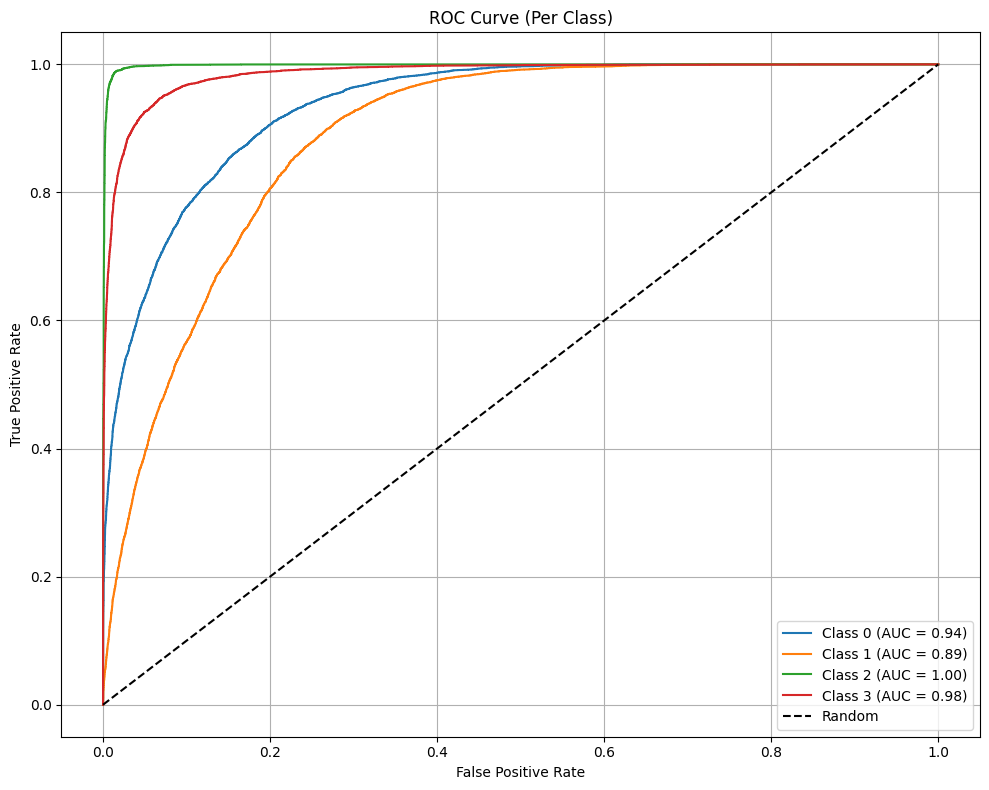

In [5]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure y_test is binarized
n_classes = 4
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, Features per epoch: 28
Valid epochs after masking: 44857

Class Distribution Before Augmentation:
Class 0: 20959 samples (46.72%)
Class 1: 20116 samples (44.84%)
Class 2: 3782 samples (8.43%)

Class Distribution After Augmentation:
Class 0: 33583 samples (44.68%)
Class 1: 32006 samples (42.58%)
Class 2: 9576 samples (12.74%)

Class Distribution After SMOTE:
Class 0: 33583 samples (33.33%)
Class 1: 33583 samples (33.33%)
Class 2: 33583 samples (33.33%)

Dynamic Focal Loss Alpha: [1.0, 1.0, 1.0]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 1024, 1)]    0           []                               
                                                             

 max_pooling1d_1 (MaxPooling1D)  (None, 256, 32)     0           ['spatial_dropout1d_1[0][0]']    
                                                                                                  
 separable_conv1d_8 (SeparableC  (None, 256, 32)     1280        ['max_pooling1d_1[0][0]']        
 onv1D)                                                                                           
                                                                                                  
 average_pooling1d (AveragePool  (None, 256, 32)     0           ['max_pooling1d_1[0][0]']        
 ing1D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 256, 32)     128         ['separable_conv1d_8[0][0]']     
 rmalization)                                                                                     
          

                                                                                                  
 layer_normalization_2 (LayerNo  (None, 128, 64)     128         ['add_2[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_5 (Dense)                (None, 32)           2080        ['dropout[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32)          128         ['dense_5[0][0]']                
 ormalization)                                                                                    
          

2519/2519 [==============================] - 207s 82ms/step - loss: 0.2733 - accuracy: 0.7855 - val_loss: 0.2851 - val_accuracy: 0.7866 - lr: 1.0000e-04
Epoch 33/100
2519/2519 [==============================] - 203s 81ms/step - loss: 0.2626 - accuracy: 0.7936 - val_loss: 0.2773 - val_accuracy: 0.7900 - lr: 1.0000e-04
Epoch 34/100
2519/2519 [==============================] - 208s 83ms/step - loss: 0.2596 - accuracy: 0.7960 - val_loss: 0.2763 - val_accuracy: 0.7902 - lr: 1.0000e-04
Epoch 35/100
2519/2519 [==============================] - 202s 80ms/step - loss: 0.2542 - accuracy: 0.7999 - val_loss: 0.2752 - val_accuracy: 0.7916 - lr: 1.0000e-04
Epoch 36/100
2519/2519 [==============================] - 204s 81ms/step - loss: 0.2503 - accuracy: 0.8037 - val_loss: 0.2750 - val_accuracy: 0.7931 - lr: 1.0000e-04
Epoch 37/100
2519/2519 [==============================] - 203s 81ms/step - loss: 0.2483 - accuracy: 0.8064 - val_loss: 0.2717 - val_accuracy: 0.7949 - lr: 1.0000e-04
Epoch 38/100
2519

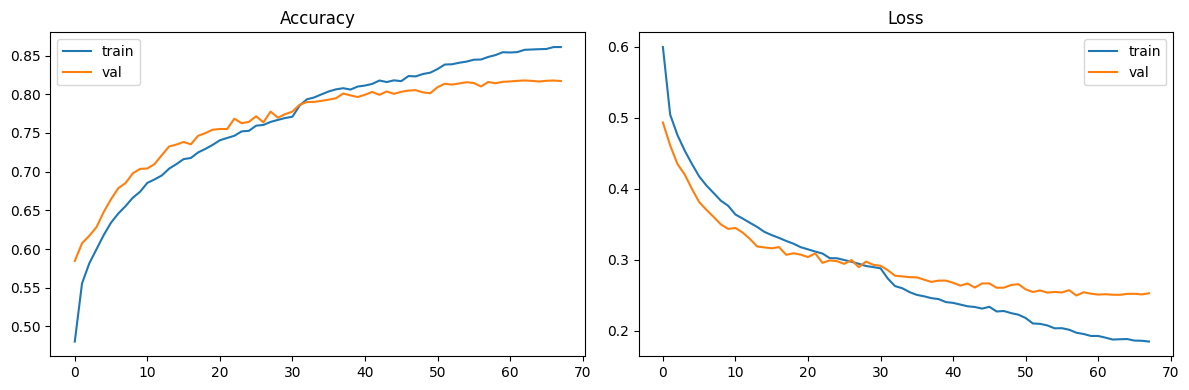

630/630 [==============================] - 11s 17ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.75      0.77      6716
           1       0.73      0.76      0.75      6717
           2       0.91      0.94      0.93      6717

    accuracy                           0.82     20150
   macro avg       0.82      0.82      0.82     20150
weighted avg       0.82      0.82      0.82     20150

Confusion Matrix:
[[5008 1542  166]
 [1155 5134  428]
 [  73  345 6299]]

🧠 Cohen Kappa Score: 0.7239


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpb3h49yas\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpb3h49yas\assets



⏱️ Total training time: 230.73 minutes


In [1]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import skew, kurtosis
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set global random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_SF = 256
TARGET_SF = 34.3
EPOCH_SAMPLES = 1024
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_SF / EPOCH_SAMPLES)
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR
DWT_LEVELS = 4
WAVELET = 'db4'
NUM_CLASSES = 3

# --- Hjorth Parameters ---
def hjorth_parameters(signal):
    try:
        activity = np.var(signal)
        diff = np.diff(signal)
        mobility = np.std(diff) / (np.std(signal) + 1e-10)
        diff2 = np.diff(diff)
        complexity = (np.std(diff2) / (np.std(diff) + 1e-10)) / (mobility + 1e-10)
        return np.array([activity, mobility, complexity])
    except Exception as e:
        print(f"Error in Hjorth parameters: {e}")
        return np.zeros(3)

# --- Preprocessing functions ---
def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    try:
        nyq = 0.5 * fs
        wp = cutoff / nyq
        b, a = cheby2(order, rs, wp, btype='low', analog=False)
        filtered = filtfilt(b, a, signal)
        return filtered
    except Exception as e:
        print(f"Error in cheby2 filter: {e}")
        return signal

def poly_detrend(signal, degree=10):
    try:
        x = np.arange(len(signal))
        coefs = Polynomial.fit(x, signal, degree).convert().coef
        trend = np.polyval(coefs[::-1], x)
        detrended = signal - trend
        return detrended
    except Exception as e:
        print(f"Error in detrending: {e}")
        return signal

def min_max_norm(signal):
    try:
        min_val = np.min(signal)
        max_val = np.max(signal)
        if max_val - min_val == 0:
            return signal * 0
        return (signal - min_val) / (max_val - min_val)
    except Exception as e:
        print(f"Error in normalization: {e}")
        return signal

def extract_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    try:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        dwt_features = []
        for c in coeffs:
            dwt_features.extend([
                np.mean(c),
                np.std(c),
                np.sum(c**2),
                skew(c, bias=False) if np.std(c) > 1e-10 else 0.0,
                kurtosis(c, bias=False) if np.std(c) > 1e-10 else 0.0
            ])
        hjorth = hjorth_parameters(signal)
        features = np.concatenate([dwt_features, hjorth])
        return np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    except Exception as e:
        print(f"Error in feature extraction: {e}")
        return np.zeros(28)

def map_to_3_classes(y):
    mapping = {
        0: 0,  # Wake
        1: 1,  # N1 -> NREM
        2: 1,  # N2 -> NREM
        3: 1,  # N3 -> NREM
        4: 2   # REM
    }
    return np.vectorize(mapping.get)(y)

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_SF, target_fs=TARGET_SF,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    try:
        filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
        detrended = poly_detrend(filtered)
        normalized = min_max_norm(detrended)
        up = int(target_fs * 1000)
        down = int(orig_fs * 1000)
        gcd = np.gcd(up, down)
        up //= gcd
        down //= gcd
        resampled = resample_poly(normalized, up, down)
        total_samples = epoch_samples * total_epochs
        if len(resampled) > total_samples:
            resampled = resampled[:total_samples]
        elif len(resampled) < total_samples:
            pad_len = total_samples - len(resampled)
            resampled = np.pad(resampled, (0, pad_len), 'constant')
        epochs = resampled.reshape(total_epochs, epoch_samples)
        mask = np.array([0 if np.sum(np.abs(e)) < 1e-10 else 1 for e in epochs])
        features = np.array([extract_features(epoch) for epoch in epochs])
        return epochs, features, mask
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return np.zeros((total_epochs, epoch_samples)), np.zeros((total_epochs, 28)), np.zeros(total_epochs)

# --- Load raw data and preprocess ---
folder_path = r"D:\abhishek_extracted\plm"
try:
    mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]
    if not mat_files:
        raise FileNotFoundError(f"No .mat files found in {folder_path}")
except Exception as e:
    print(f"Error loading files: {e}")
    exit(1)

X_epochs_list = []
X_features_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    try:
        mat = scipy.io.loadmat(file)
        raw_signal = mat['ppg_signals'].flatten()
        sleep_labels = mat['sleep_stages'].flatten()
        sleep_labels = map_to_3_classes(sleep_labels)
        epochs, features, mask = preprocess_ppg_signal(raw_signal)
        if len(sleep_labels) > epochs.shape[0]:
            sleep_labels = sleep_labels[:epochs.shape[0]]
        elif len(sleep_labels) < epochs.shape[0]:
            pad_len = epochs.shape[0] - len(sleep_labels)
            sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)
        X_epochs_list.append(epochs)
        X_features_list.append(features)
        y_epochs_list.append(sleep_labels)
        mask_list.append(mask)
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        continue

if not X_epochs_list:
    print("No valid data loaded. Exiting.")
    exit(1)

X_all = np.vstack(X_epochs_list)
X_features_all = np.vstack(X_features_list)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, Features per epoch: {X_features_all.shape[1]}")

# Save preprocessed data
try:
    np.save("ppg_epochs.npy", X_all)
    np.save("features.npy", X_features_all)
    np.save("sleep_labels_3class.npy", y_all)
    np.save("epoch_mask.npy", mask_all)
except Exception as e:
    print(f"Error saving preprocessed data: {e}")

# --- Filter out invalid epochs ---
valid_idx = (y_all != -1) & (mask_all == 1)
X_all = X_all[valid_idx]
X_features_all = X_features_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")
if len(y_all) == 0:
    print("No valid epochs after masking. Exiting.")
    exit(1)

# --- Print class distribution before augmentation ---
print("\nClass Distribution Before Augmentation:")
unique, counts = np.unique(y_all, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_all)*100:.2f}%)")

# --- Data Augmentation ---
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

np.random.seed(42)
augmented_ppg = []
augmented_features = []
augmented_labels = []
majority_classes = [0, 1]  # Wake, NREM

for ppg, feat, label in zip(X_all, X_features_all, y_all):
    augmented_ppg.append(ppg)
    augmented_features.append(feat)
    augmented_labels.append(label)
    if label in majority_classes:
        if np.random.rand() < 0.3:
            aug_ppg = jitter(ppg, sigma=0.005)
            aug_feat = jitter(feat, sigma=0.002)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.3:
            aug_ppg = scaling(ppg, sigma=0.05)
            aug_feat = scaling(feat, sigma=0.02)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
    else:
        if np.random.rand() < 0.5:
            aug_ppg = jitter(ppg)
            aug_feat = jitter(feat, sigma=0.005)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = magnitude_warp(ppg)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = scaling(ppg)
            aug_feat = scaling(feat, sigma=0.05)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)

X_aug = np.array(augmented_ppg)
X_features_aug = np.array(augmented_features)
y_aug = np.array(augmented_labels)

# --- Print class distribution after augmentation ---
print("\nClass Distribution After Augmentation:")
unique, counts = np.unique(y_aug, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_aug)*100:.2f}%)")

# --- Standardization ---
try:
    scaler_ppg = StandardScaler()
    X_scaled = scaler_ppg.fit_transform(X_aug)
    scaler_features = StandardScaler()
    X_features_scaled = scaler_features.fit_transform(X_features_aug)
except Exception as e:
    print(f"Error in standardization: {e}")
    exit(1)

# --- Validate data ---
if np.any(np.isnan(X_scaled)) or np.any(np.isinf(X_scaled)):
    raise ValueError("NaN or infinite values in X_scaled")
if np.any(np.isnan(X_features_scaled)) or np.any(np.isinf(X_features_scaled)):
    raise ValueError("NaN or infinite values in X_features_scaled")
if X_scaled.shape[0] != y_aug.shape[0] or X_features_scaled.shape[0] != y_aug.shape[0]:
    raise ValueError(f"Inconsistent sample sizes: X_scaled={X_scaled.shape[0]}, X_features_scaled={X_features_scaled.shape[0]}, y_aug={y_aug.shape[0]}")

# --- Handle Class Imbalance with SMOTE ---
try:
    X_combined = np.concatenate([X_scaled, X_features_scaled], axis=1)
    min_samples = 6  # SMOTE k_neighbors=5 requires at least 6 samples
    class_counts = np.bincount(y_aug.astype(int), minlength=NUM_CLASSES)
    if np.any(class_counts < min_samples):
        print("\nWarning: Some classes have too few samples for SMOTE. Adjusting k_neighbors.")
        k_neighbors = min(np.min(class_counts[class_counts > 0]) - 1, 5)
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors if k_neighbors > 0 else 1)
    else:
        smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_combined, y_aug)
except Exception as e:
    print(f"Error in SMOTE: {e}")
    exit(1)

# Split back into PPG and features
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_features = X_res[:, X_scaled.shape[1]:]

# --- Print class distribution after SMOTE ---
print("\nClass Distribution After SMOTE:")
unique, counts = np.unique(y_res, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_res)*100:.2f}%)")

# --- Class weights ---
try:
    class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
except Exception as e:
    print(f"Error computing class weights: {e}")
    exit(1)

# --- Train-test split ---
try:
    X_train_ppg, X_test_ppg, X_train_features, X_test_features, y_train, y_test = train_test_split(
        X_res_ppg, X_res_features, y_res, test_size=0.2, stratify=y_res, random_state=42
    )
except Exception as e:
    print(f"Error in train-test split: {e}")
    exit(1)

# Expand dims for CNN input
try:
    X_train_ppg = X_train_ppg[..., np.newaxis]
    X_test_ppg = X_test_ppg[..., np.newaxis]
except Exception as e:
    print(f"Error in expanding dimensions: {e}")
    exit(1)

# One-hot encoding
try:
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)
except Exception as e:
    print(f"Error in one-hot encoding: {e}")
    exit(1)

# --- Dynamic focal loss alpha ---
class_freq = np.bincount(y_res.astype(int), minlength=NUM_CLASSES)
alpha = 1.0 / (class_freq + 1e-10)  # Inverse frequency
alpha = alpha / np.sum(alpha) * NUM_CLASSES  # Normalize to sum to num_classes
print(f"\nDynamic Focal Loss Alpha: {alpha.tolist()}")

# --- Focal loss ---
def focal_loss(gamma=1.5, alpha=alpha):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, features_shape):
    reg = l2(1e-4)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation='relu', kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation='sigmoid', kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)
    features_input = Input(shape=features_shape, name='features_input')
    d = GaussianNoise(0.02)(features_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    features_out = d
    combined = Concatenate()([ppg_out, features_out])
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=[ppg_input, features_input], outputs=outputs)

# --- Compile & train ---
try:
    model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_features.shape[1],))
    model.compile(optimizer=Adam(2e-4),
                  loss=focal_loss(gamma=1.5),
                  metrics=['accuracy'])
except Exception as e:
    print(f"Error building/compiling model: {e}")
    exit(1)

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_features_3class.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

try:
    history = model.fit([X_train_ppg, X_train_features], y_train_cat,
                        validation_data=([X_test_ppg, X_test_features], y_test_cat),
                        epochs=100, batch_size=32, class_weight=class_weight_dict,
                        callbacks=callbacks, verbose=1)
except Exception as e:
    print(f"Error during training: {e}")
    exit(1)

end_time = time.time()

# --- Plot training curves ---
try:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error plotting curves: {e}")

# --- Evaluation ---
try:
    y_pred = model.predict([X_test_ppg, X_test_features])
    y_pred_cls = np.argmax(y_pred, axis=1)
    y_true_cls = np.argmax(y_test_cat, axis=1)
    print("\nClassification Report:")
    print(classification_report(y_true_cls, y_pred_cls))
    cm = confusion_matrix(y_true_cls, y_pred_cls)
    print("Confusion Matrix:")
    print(cm)
    kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
    print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")
except Exception as e:
    print(f"Error during evaluation: {e}")
    exit(1)

# --- Save model ---
try:
    model.save("cnn_features_rvfl_light_model_3class.keras")
except Exception as e:
    print(f"Error saving model: {e}")

# --- Export TFLite ---
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open("cnn_features_rvfl_light_model_3class.tflite", "wb") as f:
        f.write(tflite_model)
except Exception as e:
    print(f"Error exporting TFLite: {e}")

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

In [2]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")


✅ Overall Test Accuracy: 0.8159


In [3]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Macro F1 Score:", f1_score(y_true_cls, y_pred_cls, average='macro'))
print("Weighted F1 Score:", f1_score(y_true_cls, y_pred_cls, average='weighted'))
print("Macro Precision:", precision_score(y_true_cls, y_pred_cls, average='macro'))
print("Macro Recall:", recall_score(y_true_cls, y_pred_cls, average='macro'))


Macro F1 Score: 0.8154585661709349
Weighted F1 Score: 0.8154606575706326
Macro Precision: 0.8160464612503865
Macro Recall: 0.8159270349835513


In [4]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
print(f"📉 Final Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")


📈 Final Accuracy: Train = 0.8611, Val = 0.8172
📉 Final Loss: Train = 0.1845, Val = 0.2525


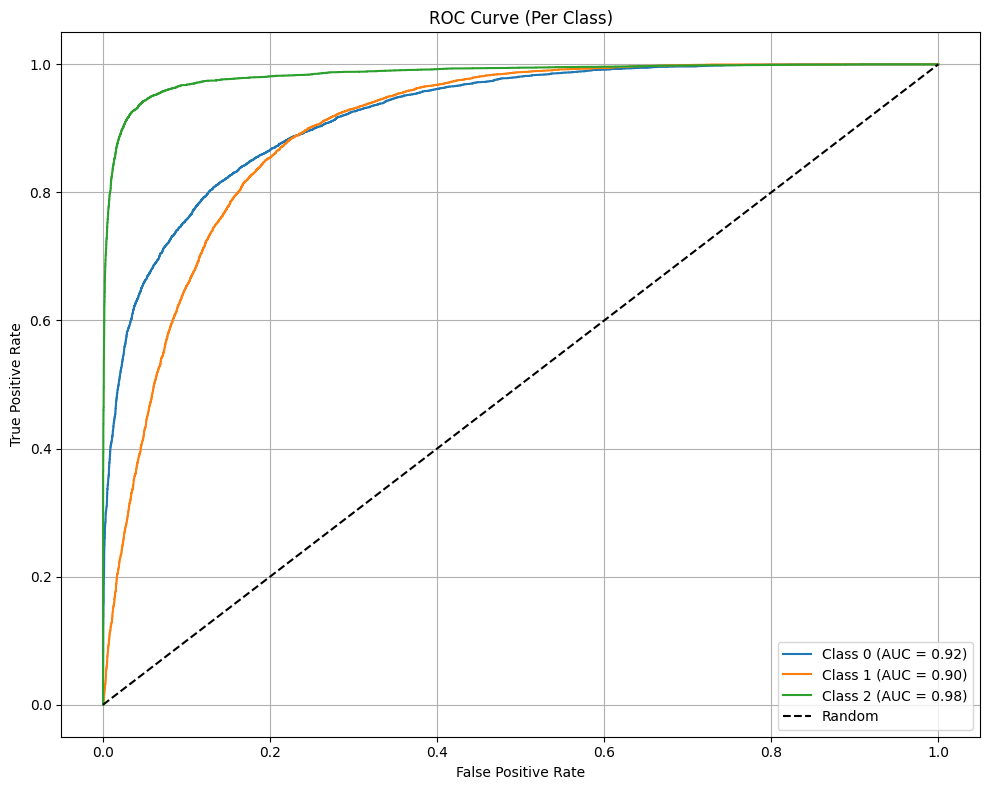

In [6]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure y_test is binarized
n_classes = 3
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, Features per epoch: 28
Valid epochs after masking: 44857

Class Distribution Before Augmentation:
Class 0: 20959 samples (46.72%)
Class 1: 20116 samples (44.84%)
Class 2: 3782 samples (8.43%)

Class Distribution After Augmentation:
Class 0: 33583 samples (44.68%)
Class 1: 32006 samples (42.58%)
Class 2: 9576 samples (12.74%)

Class Distribution After SMOTE:
Class 0: 33583 samples (33.33%)
Class 1: 33583 samples (33.33%)
Class 2: 33583 samples (33.33%)

Fixed Focal Loss Alpha: [0.12, 0.138, 0.742]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 1024, 1)]    0           []                               
                                                          

 max_pooling1d_1 (MaxPooling1D)  (None, 256, 32)     0           ['spatial_dropout1d_1[0][0]']    
                                                                                                  
 separable_conv1d_8 (SeparableC  (None, 256, 32)     1280        ['max_pooling1d_1[0][0]']        
 onv1D)                                                                                           
                                                                                                  
 average_pooling1d (AveragePool  (None, 256, 32)     0           ['max_pooling1d_1[0][0]']        
 ing1D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 256, 32)     128         ['separable_conv1d_8[0][0]']     
 rmalization)                                                                                     
          

                                                                                                  
 layer_normalization_2 (LayerNo  (None, 128, 64)     128         ['add_2[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_5 (Dense)                (None, 32)           2080        ['dropout[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32)          128         ['dense_5[0][0]']                
 ormalization)                                                                                    
          

2519/2519 [==============================] - 201s 80ms/step - loss: 0.0594 - accuracy: 0.7373 - val_loss: 0.0645 - val_accuracy: 0.7118 - lr: 5.0000e-05
Epoch 33/100
2519/2519 [==============================] - 198s 79ms/step - loss: 0.0583 - accuracy: 0.7384 - val_loss: 0.0647 - val_accuracy: 0.7167 - lr: 5.0000e-05
Epoch 34/100
2519/2519 [==============================] - 198s 79ms/step - loss: 0.0580 - accuracy: 0.7403 - val_loss: 0.0644 - val_accuracy: 0.7257 - lr: 5.0000e-05
Epoch 35/100
2519/2519 [==============================] - 202s 80ms/step - loss: 0.0574 - accuracy: 0.7429 - val_loss: 0.0628 - val_accuracy: 0.7268 - lr: 5.0000e-05
Epoch 36/100
2519/2519 [==============================] - 200s 79ms/step - loss: 0.0575 - accuracy: 0.7449 - val_loss: 0.0625 - val_accuracy: 0.7233 - lr: 5.0000e-05
Epoch 37/100
2519/2519 [==============================] - 200s 79ms/step - loss: 0.0566 - accuracy: 0.7459 - val_loss: 0.0646 - val_accuracy: 0.7151 - lr: 5.0000e-05
Epoch 38/100
2519

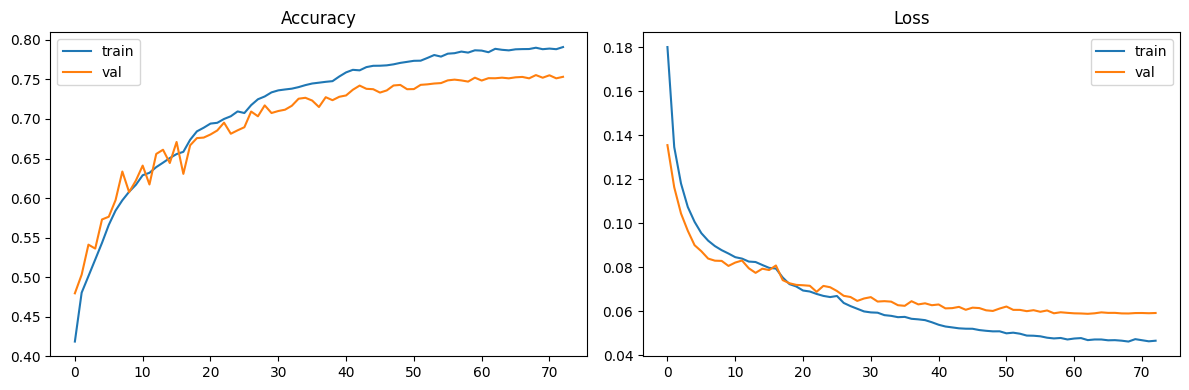

630/630 [==============================] - 11s 16ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.64      0.72      6716
           1       0.69      0.64      0.67      6717
           2       0.76      0.97      0.85      6717

    accuracy                           0.75     20150
   macro avg       0.75      0.75      0.74     20150
weighted avg       0.75      0.75      0.74     20150

Confusion Matrix:
[[4296 1789  631]
 [ 949 4318 1450]
 [  27  161 6529]]

🧠 Cohen Kappa Score: 0.6273


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpp02n1fhl\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpp02n1fhl\assets



⏱️ Total training time: 243.14 minutes


In [1]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import skew, kurtosis
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set global random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_SF = 256
TARGET_SF = 34.3
EPOCH_SAMPLES = 1024
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_SF / EPOCH_SAMPLES)
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR
DWT_LEVELS = 4
WAVELET = 'db4'
NUM_CLASSES = 3

# --- Hjorth Parameters ---
def hjorth_parameters(signal):
    try:
        activity = np.var(signal)
        diff = np.diff(signal)
        mobility = np.std(diff) / (np.std(signal) + 1e-10)
        diff2 = np.diff(diff)
        complexity = (np.std(diff2) / (np.std(diff) + 1e-10)) / (mobility + 1e-10)
        return np.array([activity, mobility, complexity])
    except Exception as e:
        print(f"Error in Hjorth parameters: {e}")
        return np.zeros(3)

# --- Preprocessing functions ---
def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    try:
        nyq = 0.5 * fs
        wp = cutoff / nyq
        b, a = cheby2(order, rs, wp, btype='low', analog=False)
        filtered = filtfilt(b, a, signal)
        return filtered
    except Exception as e:
        print(f"Error in cheby2 filter: {e}")
        return signal

def poly_detrend(signal, degree=10):
    try:
        x = np.arange(len(signal))
        coefs = Polynomial.fit(x, signal, degree).convert().coef
        trend = np.polyval(coefs[::-1], x)
        detrended = signal - trend
        return detrended
    except Exception as e:
        print(f"Error in detrending: {e}")
        return signal

def min_max_norm(signal):
    try:
        min_val = np.min(signal)
        max_val = np.max(signal)
        if max_val - min_val == 0:
            return signal * 0
        return (signal - min_val) / (max_val - min_val)
    except Exception as e:
        print(f"Error in normalization: {e}")
        return signal

def extract_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    try:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        dwt_features = []
        for c in coeffs:
            dwt_features.extend([
                np.mean(c),
                np.std(c),
                np.sum(c**2),
                skew(c, bias=False) if np.std(c) > 1e-10 else 0.0,
                kurtosis(c, bias=False) if np.std(c) > 1e-10 else 0.0
            ])
        hjorth = hjorth_parameters(signal)
        features = np.concatenate([dwt_features, hjorth])
        return np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    except Exception as e:
        print(f"Error in feature extraction: {e}")
        return np.zeros(28)

def map_to_3_classes(y):
    mapping = {
        0: 0,  # Wake
        1: 1,  # N1 -> NREM
        2: 1,  # N2 -> NREM
        3: 1,  # N3 -> NREM
        4: 2   # REM
    }
    return np.vectorize(mapping.get)(y)

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_SF, target_fs=TARGET_SF,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    try:
        filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
        detrended = poly_detrend(filtered)
        normalized = min_max_norm(detrended)
        up = int(target_fs * 1000)
        down = int(orig_fs * 1000)
        gcd = np.gcd(up, down)
        up //= gcd
        down //= gcd
        resampled = resample_poly(normalized, up, down)
        total_samples = epoch_samples * total_epochs
        if len(resampled) > total_samples:
            resampled = resampled[:total_samples]
        elif len(resampled) < total_samples:
            pad_len = total_samples - len(resampled)
            resampled = np.pad(resampled, (0, pad_len), 'constant')
        epochs = resampled.reshape(total_epochs, epoch_samples)
        mask = np.array([0 if np.sum(np.abs(e)) < 1e-10 else 1 for e in epochs])
        features = np.array([extract_features(epoch) for epoch in epochs])
        return epochs, features, mask
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return np.zeros((total_epochs, epoch_samples)), np.zeros((total_epochs, 28)), np.zeros(total_epochs)

# --- Load raw data and preprocess ---
folder_path = r"D:\abhishek_extracted\plm"
try:
    mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]
    if not mat_files:
        raise FileNotFoundError(f"No .mat files found in {folder_path}")
except Exception as e:
    print(f"Error loading files: {e}")
    exit(1)

X_epochs_list = []
X_features_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    try:
        mat = scipy.io.loadmat(file)
        raw_signal = mat['ppg_signals'].flatten()
        sleep_labels = mat['sleep_stages'].flatten()
        sleep_labels = map_to_3_classes(sleep_labels)
        epochs, features, mask = preprocess_ppg_signal(raw_signal)
        if len(sleep_labels) > epochs.shape[0]:
            sleep_labels = sleep_labels[:epochs.shape[0]]
        elif len(sleep_labels) < epochs.shape[0]:
            pad_len = epochs.shape[0] - len(sleep_labels)
            sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)
        X_epochs_list.append(epochs)
        X_features_list.append(features)
        y_epochs_list.append(sleep_labels)
        mask_list.append(mask)
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        continue

if not X_epochs_list:
    print("No valid data loaded. Exiting.")
    exit(1)

X_all = np.vstack(X_epochs_list)
X_features_all = np.vstack(X_features_list)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, Features per epoch: {X_features_all.shape[1]}")

# Save preprocessed data
try:
    np.save("ppg_epochs.npy", X_all)
    np.save("features.npy", X_features_all)
    np.save("sleep_labels_3class.npy", y_all)
    np.save("epoch_mask.npy", mask_all)
except Exception as e:
    print(f"Error saving preprocessed data: {e}")

# --- Filter out invalid epochs ---
valid_idx = (y_all != -1) & (mask_all == 1)
X_all = X_all[valid_idx]
X_features_all = X_features_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")
if len(y_all) == 0:
    print("No valid epochs after masking. Exiting.")
    exit(1)

# --- Print class distribution before augmentation ---
print("\nClass Distribution Before Augmentation:")
unique, counts = np.unique(y_all, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_all)*100:.2f}%)")

# --- Data Augmentation ---
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

np.random.seed(42)
augmented_ppg = []
augmented_features = []
augmented_labels = []
majority_classes = [0, 1]  # Wake, NREM

for ppg, feat, label in zip(X_all, X_features_all, y_all):
    augmented_ppg.append(ppg)
    augmented_features.append(feat)
    augmented_labels.append(label)
    if label in majority_classes:
        if np.random.rand() < 0.3:
            aug_ppg = jitter(ppg, sigma=0.005)
            aug_feat = jitter(feat, sigma=0.002)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.3:
            aug_ppg = scaling(ppg, sigma=0.05)
            aug_feat = scaling(feat, sigma=0.02)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
    else:
        if np.random.rand() < 0.5:
            aug_ppg = jitter(ppg)
            aug_feat = jitter(feat, sigma=0.005)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = magnitude_warp(ppg)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = scaling(ppg)
            aug_feat = scaling(feat, sigma=0.05)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)

X_aug = np.array(augmented_ppg)
X_features_aug = np.array(augmented_features)
y_aug = np.array(augmented_labels)

# --- Print class distribution after augmentation ---
print("\nClass Distribution After Augmentation:")
unique, counts = np.unique(y_aug, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_aug)*100:.2f}%)")

# --- Standardization ---
try:
    scaler_ppg = StandardScaler()
    X_scaled = scaler_ppg.fit_transform(X_aug)
    scaler_features = StandardScaler()
    X_features_scaled = scaler_features.fit_transform(X_features_aug)
except Exception as e:
    print(f"Error in standardization: {e}")
    exit(1)

# --- Validate data ---
if np.any(np.isnan(X_scaled)) or np.any(np.isinf(X_scaled)):
    raise ValueError("NaN or infinite values in X_scaled")
if np.any(np.isnan(X_features_scaled)) or np.any(np.isinf(X_features_scaled)):
    raise ValueError("NaN or infinite values in X_features_scaled")
if X_scaled.shape[0] != y_aug.shape[0] or X_features_scaled.shape[0] != y_aug.shape[0]:
    raise ValueError(f"Inconsistent sample sizes: X_scaled={X_scaled.shape[0]}, X_features_scaled={X_features_scaled.shape[0]}, y_aug={y_aug.shape[0]}")

# --- Handle Class Imbalance with SMOTE ---
try:
    X_combined = np.concatenate([X_scaled, X_features_scaled], axis=1)
    min_samples = 6  # SMOTE k_neighbors=5 requires at least 6 samples
    class_counts = np.bincount(y_aug.astype(int), minlength=NUM_CLASSES)
    if np.any(class_counts < min_samples):
        print("\nWarning: Some classes have too few samples for SMOTE. Adjusting k_neighbors.")
        k_neighbors = min(np.min(class_counts[class_counts > 0]) - 1, 5)
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors if k_neighbors > 0 else 1)
    else:
        smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_combined, y_aug)
except Exception as e:
    print(f"Error in SMOTE: {e}")
    exit(1)

# Split back into PPG and features
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_features = X_res[:, X_scaled.shape[1]:]

# --- Print class distribution after SMOTE ---
print("\nClass Distribution After SMOTE:")
unique, counts = np.unique(y_res, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_res)*100:.2f}%)")

# --- Class weights ---
try:
    class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
except Exception as e:
    print(f"Error computing class weights: {e}")
    exit(1)

# --- Train-test split ---
try:
    X_train_ppg, X_test_ppg, X_train_features, X_test_features, y_train, y_test = train_test_split(
        X_res_ppg, X_res_features, y_res, test_size=0.2, stratify=y_res, random_state=42
    )
except Exception as e:
    print(f"Error in train-test split: {e}")
    exit(1)

# Expand dims for CNN input
try:
    X_train_ppg = X_train_ppg[..., np.newaxis]
    X_test_ppg = X_test_ppg[..., np.newaxis]
except Exception as e:
    print(f"Error in expanding dimensions: {e}")
    exit(1)

# One-hot encoding
try:
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)
except Exception as e:
    print(f"Error in one-hot encoding: {e}")
    exit(1)

# --- Fixed focal loss alpha ---
alpha = [0.120, 0.138, 0.742]
print(f"\nFixed Focal Loss Alpha: {alpha}")

# --- Focal loss ---
def focal_loss(gamma=1.5, alpha=alpha):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, features_shape):
    reg = l2(1e-4)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation='relu', kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation='sigmoid', kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)
    features_input = Input(shape=features_shape, name='features_input')
    d = GaussianNoise(0.02)(features_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    features_out = d
    combined = Concatenate()([ppg_out, features_out])
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=[ppg_input, features_input], outputs=outputs)

# --- Compile & train ---
try:
    model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_features.shape[1],))
    model.compile(optimizer=Adam(2e-4),
                  loss=focal_loss(gamma=1.5),
                  metrics=['accuracy'])
except Exception as e:
    print(f"Error building/compiling model: {e}")
    exit(1)

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_features_3class.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

try:
    history = model.fit([X_train_ppg, X_train_features], y_train_cat,
                        validation_data=([X_test_ppg, X_test_features], y_test_cat),
                        epochs=100, batch_size=32, class_weight=class_weight_dict,
                        callbacks=callbacks, verbose=1)
except Exception as e:
    print(f"Error during training: {e}")
    exit(1)

end_time = time.time()

# --- Plot training curves ---
try:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error plotting curves: {e}")

# --- Evaluation ---
try:
    y_pred = model.predict([X_test_ppg, X_test_features])
    y_pred_cls = np.argmax(y_pred, axis=1)
    y_true_cls = np.argmax(y_test_cat, axis=1)
    print("\nClassification Report:")
    print(classification_report(y_true_cls, y_pred_cls))
    cm = confusion_matrix(y_true_cls, y_pred_cls)
    print("Confusion Matrix:")
    print(cm)
    kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
    print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")
except Exception as e:
    print(f"Error during evaluation: {e}")
    exit(1)

# --- Save model ---
try:
    model.save("cnn_features_rvfl_light_model_3class.keras")
except Exception as e:
    print(f"Error saving model: {e}")

# --- Export TFLite ---
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open("cnn_features_rvfl_light_model_3class.tflite", "wb") as f:
        f.write(tflite_model)
except Exception as e:
    print(f"Error exporting TFLite: {e}")

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

In [2]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")


✅ Overall Test Accuracy: 0.7515


In [3]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Macro F1 Score:", f1_score(y_true_cls, y_pred_cls, average='macro'))
print("Weighted F1 Score:", f1_score(y_true_cls, y_pred_cls, average='weighted'))
print("Macro Precision:", precision_score(y_true_cls, y_pred_cls, average='macro'))
print("Macro Recall:", recall_score(y_true_cls, y_pred_cls, average='macro'))


Macro F1 Score: 0.7445841319245844
Weighted F1 Score: 0.7445855149228577
Macro Precision: 0.7540237645331528
Macro Recall: 0.7515080971896251


In [4]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
print(f"📉 Final Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")


📈 Final Accuracy: Train = 0.7910, Val = 0.7533
📉 Final Loss: Train = 0.0467, Val = 0.0593


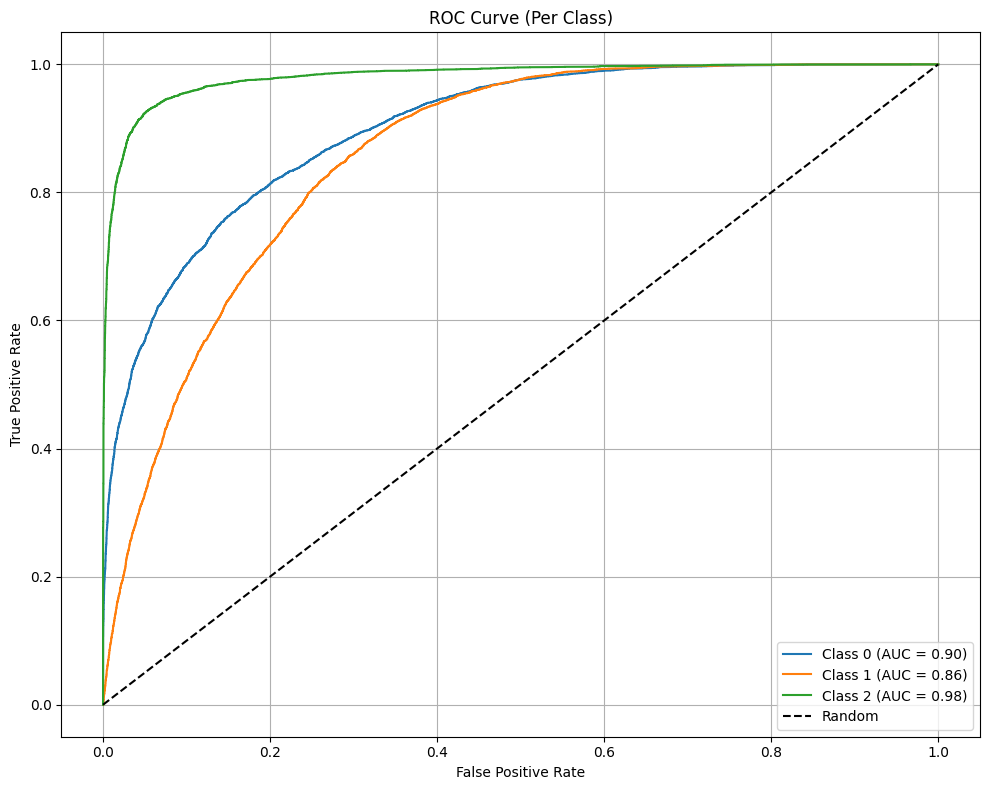

In [5]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure y_test is binarized
n_classes = 3
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, Features per epoch: 28
Valid epochs after masking: 44857

Class Distribution Before Augmentation:
Class 0: 20959 samples (46.72%)
Class 1: 23898 samples (53.28%)

Class Distribution After Augmentation:
Class 0: 33571 samples (46.71%)
Class 1: 38302 samples (53.29%)

Class Distribution After SMOTE:
Class 0: 38302 samples (50.00%)
Class 1: 38302 samples (50.00%)

Fixed Focal Loss Alpha: [0.507, 0.493]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 1024, 1)]    0           []                               
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 1024, 1)     0    

                                                                                                  
 separable_conv1d_8 (SeparableC  (None, 256, 32)     1280        ['max_pooling1d_1[0][0]']        
 onv1D)                                                                                           
                                                                                                  
 average_pooling1d (AveragePool  (None, 256, 32)     0           ['max_pooling1d_1[0][0]']        
 ing1D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 256, 32)     128         ['separable_conv1d_8[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 tf.math.s

 layer_normalization_2 (LayerNo  (None, 128, 64)     128         ['add_2[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_5 (Dense)                (None, 32)           2080        ['dropout[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32)          128         ['dense_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 concatena

Epoch 33/100
1916/1916 [==============================] - 157s 82ms/step - loss: 0.0762 - accuracy: 0.8313 - val_loss: 0.0879 - val_accuracy: 0.8015 - lr: 5.0000e-05
Epoch 34/100
1916/1916 [==============================] - 157s 82ms/step - loss: 0.0755 - accuracy: 0.8333 - val_loss: 0.0883 - val_accuracy: 0.8050 - lr: 5.0000e-05
Epoch 35/100
1916/1916 [==============================] - 153s 80ms/step - loss: 0.0749 - accuracy: 0.8334 - val_loss: 0.0887 - val_accuracy: 0.8026 - lr: 5.0000e-05
Epoch 36/100
1916/1916 [==============================] - 157s 82ms/step - loss: 0.0735 - accuracy: 0.8387 - val_loss: 0.0893 - val_accuracy: 0.8020 - lr: 5.0000e-05
Epoch 37/100
1916/1916 [==============================] - 160s 83ms/step - loss: 0.0720 - accuracy: 0.8440 - val_loss: 0.0878 - val_accuracy: 0.8093 - lr: 2.5000e-05
Epoch 38/100
1916/1916 [==============================] - 160s 84ms/step - loss: 0.0707 - accuracy: 0.8513 - val_loss: 0.0881 - val_accuracy: 0.8080 - lr: 2.5000e-05
Epoc

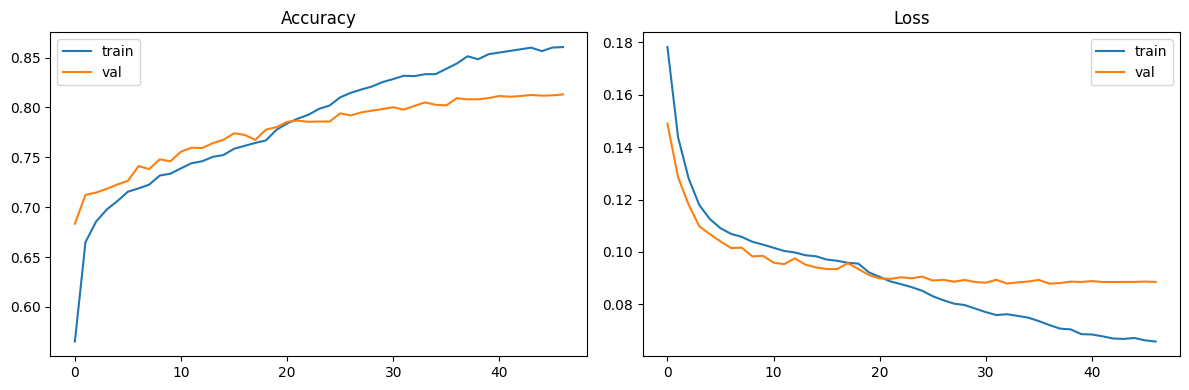

479/479 [==============================] - 9s 18ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      7661
           1       0.79      0.85      0.82      7660

    accuracy                           0.81     15321
   macro avg       0.81      0.81      0.81     15321
weighted avg       0.81      0.81      0.81     15321

Confusion Matrix:
[[5924 1737]
 [1185 6475]]

🧠 Cohen Kappa Score: 0.6186


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp28hl02nv\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp28hl02nv\assets



⏱️ Total training time: 123.49 minutes


In [6]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import skew, kurtosis
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set global random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_SF = 256
TARGET_SF = 34.3
EPOCH_SAMPLES = 1024
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_SF / EPOCH_SAMPLES)
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR
DWT_LEVELS = 4
WAVELET = 'db4'
NUM_CLASSES = 2

# --- Hjorth Parameters ---
def hjorth_parameters(signal):
    try:
        activity = np.var(signal)
        diff = np.diff(signal)
        mobility = np.std(diff) / (np.std(signal) + 1e-10)
        diff2 = np.diff(diff)
        complexity = (np.std(diff2) / (np.std(diff) + 1e-10)) / (mobility + 1e-10)
        return np.array([activity, mobility, complexity])
    except Exception as e:
        print(f"Error in Hjorth parameters: {e}")
        return np.zeros(3)

# --- Preprocessing functions ---
def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    try:
        nyq = 0.5 * fs
        wp = cutoff / nyq
        b, a = cheby2(order, rs, wp, btype='low', analog=False)
        filtered = filtfilt(b, a, signal)
        return filtered
    except Exception as e:
        print(f"Error in cheby2 filter: {e}")
        return signal

def poly_detrend(signal, degree=10):
    try:
        x = np.arange(len(signal))
        coefs = Polynomial.fit(x, signal, degree).convert().coef
        trend = np.polyval(coefs[::-1], x)
        detrended = signal - trend
        return detrended
    except Exception as e:
        print(f"Error in detrending: {e}")
        return signal

def min_max_norm(signal):
    try:
        min_val = np.min(signal)
        max_val = np.max(signal)
        if max_val - min_val == 0:
            return signal * 0
        return (signal - min_val) / (max_val - min_val)
    except Exception as e:
        print(f"Error in normalization: {e}")
        return signal

def extract_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    try:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        dwt_features = []
        for c in coeffs:
            dwt_features.extend([
                np.mean(c),
                np.std(c),
                np.sum(c**2),
                skew(c, bias=False) if np.std(c) > 1e-10 else 0.0,
                kurtosis(c, bias=False) if np.std(c) > 1e-10 else 0.0
            ])
        hjorth = hjorth_parameters(signal)
        features = np.concatenate([dwt_features, hjorth])
        return np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    except Exception as e:
        print(f"Error in feature extraction: {e}")
        return np.zeros(28)

def map_to_3_classes(y):
    mapping = {
        0: 0,  # Wake
        1: 1,  # N1 -> NREM
        2: 1,  # N2 -> NREM
        3: 1,  # N3 -> NREM
        4: 1   # REM
    }
    return np.vectorize(mapping.get)(y)

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_SF, target_fs=TARGET_SF,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    try:
        filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
        detrended = poly_detrend(filtered)
        normalized = min_max_norm(detrended)
        up = int(target_fs * 1000)
        down = int(orig_fs * 1000)
        gcd = np.gcd(up, down)
        up //= gcd
        down //= gcd
        resampled = resample_poly(normalized, up, down)
        total_samples = epoch_samples * total_epochs
        if len(resampled) > total_samples:
            resampled = resampled[:total_samples]
        elif len(resampled) < total_samples:
            pad_len = total_samples - len(resampled)
            resampled = np.pad(resampled, (0, pad_len), 'constant')
        epochs = resampled.reshape(total_epochs, epoch_samples)
        mask = np.array([0 if np.sum(np.abs(e)) < 1e-10 else 1 for e in epochs])
        features = np.array([extract_features(epoch) for epoch in epochs])
        return epochs, features, mask
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return np.zeros((total_epochs, epoch_samples)), np.zeros((total_epochs, 28)), np.zeros(total_epochs)

# --- Load raw data and preprocess ---
folder_path = r"D:\abhishek_extracted\plm"
try:
    mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]
    if not mat_files:
        raise FileNotFoundError(f"No .mat files found in {folder_path}")
except Exception as e:
    print(f"Error loading files: {e}")
    exit(1)

X_epochs_list = []
X_features_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    try:
        mat = scipy.io.loadmat(file)
        raw_signal = mat['ppg_signals'].flatten()
        sleep_labels = mat['sleep_stages'].flatten()
        sleep_labels = map_to_3_classes(sleep_labels)
        epochs, features, mask = preprocess_ppg_signal(raw_signal)
        if len(sleep_labels) > epochs.shape[0]:
            sleep_labels = sleep_labels[:epochs.shape[0]]
        elif len(sleep_labels) < epochs.shape[0]:
            pad_len = epochs.shape[0] - len(sleep_labels)
            sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)
        X_epochs_list.append(epochs)
        X_features_list.append(features)
        y_epochs_list.append(sleep_labels)
        mask_list.append(mask)
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        continue

if not X_epochs_list:
    print("No valid data loaded. Exiting.")
    exit(1)

X_all = np.vstack(X_epochs_list)
X_features_all = np.vstack(X_features_list)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, Features per epoch: {X_features_all.shape[1]}")

# Save preprocessed data
try:
    np.save("ppg_epochs.npy", X_all)
    np.save("features.npy", X_features_all)
    np.save("sleep_labels_3class.npy", y_all)
    np.save("epoch_mask.npy", mask_all)
except Exception as e:
    print(f"Error saving preprocessed data: {e}")

# --- Filter out invalid epochs ---
valid_idx = (y_all != -1) & (mask_all == 1)
X_all = X_all[valid_idx]
X_features_all = X_features_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")
if len(y_all) == 0:
    print("No valid epochs after masking. Exiting.")
    exit(1)

# --- Print class distribution before augmentation ---
print("\nClass Distribution Before Augmentation:")
unique, counts = np.unique(y_all, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_all)*100:.2f}%)")

# --- Data Augmentation ---
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

np.random.seed(42)
augmented_ppg = []
augmented_features = []
augmented_labels = []
majority_classes = [0, 1]  # Wake, NREM

for ppg, feat, label in zip(X_all, X_features_all, y_all):
    augmented_ppg.append(ppg)
    augmented_features.append(feat)
    augmented_labels.append(label)
    if label in majority_classes:
        if np.random.rand() < 0.3:
            aug_ppg = jitter(ppg, sigma=0.005)
            aug_feat = jitter(feat, sigma=0.002)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.3:
            aug_ppg = scaling(ppg, sigma=0.05)
            aug_feat = scaling(feat, sigma=0.02)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
    else:
        if np.random.rand() < 0.5:
            aug_ppg = jitter(ppg)
            aug_feat = jitter(feat, sigma=0.005)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = magnitude_warp(ppg)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = scaling(ppg)
            aug_feat = scaling(feat, sigma=0.05)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)

X_aug = np.array(augmented_ppg)
X_features_aug = np.array(augmented_features)
y_aug = np.array(augmented_labels)

# --- Print class distribution after augmentation ---
print("\nClass Distribution After Augmentation:")
unique, counts = np.unique(y_aug, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_aug)*100:.2f}%)")

# --- Standardization ---
try:
    scaler_ppg = StandardScaler()
    X_scaled = scaler_ppg.fit_transform(X_aug)
    scaler_features = StandardScaler()
    X_features_scaled = scaler_features.fit_transform(X_features_aug)
except Exception as e:
    print(f"Error in standardization: {e}")
    exit(1)

# --- Validate data ---
if np.any(np.isnan(X_scaled)) or np.any(np.isinf(X_scaled)):
    raise ValueError("NaN or infinite values in X_scaled")
if np.any(np.isnan(X_features_scaled)) or np.any(np.isinf(X_features_scaled)):
    raise ValueError("NaN or infinite values in X_features_scaled")
if X_scaled.shape[0] != y_aug.shape[0] or X_features_scaled.shape[0] != y_aug.shape[0]:
    raise ValueError(f"Inconsistent sample sizes: X_scaled={X_scaled.shape[0]}, X_features_scaled={X_features_scaled.shape[0]}, y_aug={y_aug.shape[0]}")

# --- Handle Class Imbalance with SMOTE ---
try:
    X_combined = np.concatenate([X_scaled, X_features_scaled], axis=1)
    min_samples = 6  # SMOTE k_neighbors=5 requires at least 6 samples
    class_counts = np.bincount(y_aug.astype(int), minlength=NUM_CLASSES)
    if np.any(class_counts < min_samples):
        print("\nWarning: Some classes have too few samples for SMOTE. Adjusting k_neighbors.")
        k_neighbors = min(np.min(class_counts[class_counts > 0]) - 1, 5)
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors if k_neighbors > 0 else 1)
    else:
        smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_combined, y_aug)
except Exception as e:
    print(f"Error in SMOTE: {e}")
    exit(1)

# Split back into PPG and features
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_features = X_res[:, X_scaled.shape[1]:]

# --- Print class distribution after SMOTE ---
print("\nClass Distribution After SMOTE:")
unique, counts = np.unique(y_res, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_res)*100:.2f}%)")

# --- Class weights ---
try:
    class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
except Exception as e:
    print(f"Error computing class weights: {e}")
    exit(1)

# --- Train-test split ---
try:
    X_train_ppg, X_test_ppg, X_train_features, X_test_features, y_train, y_test = train_test_split(
        X_res_ppg, X_res_features, y_res, test_size=0.2, stratify=y_res, random_state=42
    )
except Exception as e:
    print(f"Error in train-test split: {e}")
    exit(1)

# Expand dims for CNN input
try:
    X_train_ppg = X_train_ppg[..., np.newaxis]
    X_test_ppg = X_test_ppg[..., np.newaxis]
except Exception as e:
    print(f"Error in expanding dimensions: {e}")
    exit(1)

# One-hot encoding
try:
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)
except Exception as e:
    print(f"Error in one-hot encoding: {e}")
    exit(1)

# --- Fixed focal loss alpha ---
alpha = [0.507, 0.493]
print(f"\nFixed Focal Loss Alpha: {alpha}")

# --- Focal loss ---
def focal_loss(gamma=1.5, alpha=alpha):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, features_shape):
    reg = l2(1e-4)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation='relu', kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation='sigmoid', kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)
    features_input = Input(shape=features_shape, name='features_input')
    d = GaussianNoise(0.02)(features_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    features_out = d
    combined = Concatenate()([ppg_out, features_out])
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=[ppg_input, features_input], outputs=outputs)

# --- Compile & train ---
try:
    model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_features.shape[1],))
    model.compile(optimizer=Adam(2e-4),
                  loss=focal_loss(gamma=1.5),
                  metrics=['accuracy'])
except Exception as e:
    print(f"Error building/compiling model: {e}")
    exit(1)

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_features_3class.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

try:
    history = model.fit([X_train_ppg, X_train_features], y_train_cat,
                        validation_data=([X_test_ppg, X_test_features], y_test_cat),
                        epochs=100, batch_size=32, class_weight=class_weight_dict,
                        callbacks=callbacks, verbose=1)
except Exception as e:
    print(f"Error during training: {e}")
    exit(1)

end_time = time.time()

# --- Plot training curves ---
try:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error plotting curves: {e}")

# --- Evaluation ---
try:
    y_pred = model.predict([X_test_ppg, X_test_features])
    y_pred_cls = np.argmax(y_pred, axis=1)
    y_true_cls = np.argmax(y_test_cat, axis=1)
    print("\nClassification Report:")
    print(classification_report(y_true_cls, y_pred_cls))
    cm = confusion_matrix(y_true_cls, y_pred_cls)
    print("Confusion Matrix:")
    print(cm)
    kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
    print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")
except Exception as e:
    print(f"Error during evaluation: {e}")
    exit(1)

# --- Save model ---
try:
    model.save("cnn_features_rvfl_light_model_3class.keras")
except Exception as e:
    print(f"Error saving model: {e}")

# --- Export TFLite ---
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open("cnn_features_rvfl_light_model_3class.tflite", "wb") as f:
        f.write(tflite_model)
except Exception as e:
    print(f"Error exporting TFLite: {e}")

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

In [7]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")


✅ Overall Test Accuracy: 0.8093


In [8]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Macro F1 Score:", f1_score(y_true_cls, y_pred_cls, average='macro'))
print("Weighted F1 Score:", f1_score(y_true_cls, y_pred_cls, average='weighted'))
print("Macro Precision:", precision_score(y_true_cls, y_pred_cls, average='macro'))
print("Macro Recall:", recall_score(y_true_cls, y_pred_cls, average='macro'))


Macro F1 Score: 0.8090343857836286
Weighted F1 Score: 0.8090339375209853
Macro Precision: 0.8108950808224066
Macro Recall: 0.8092837292952028


In [9]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
print(f"📉 Final Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")


📈 Final Accuracy: Train = 0.8605, Val = 0.8130
📉 Final Loss: Train = 0.0657, Val = 0.0885


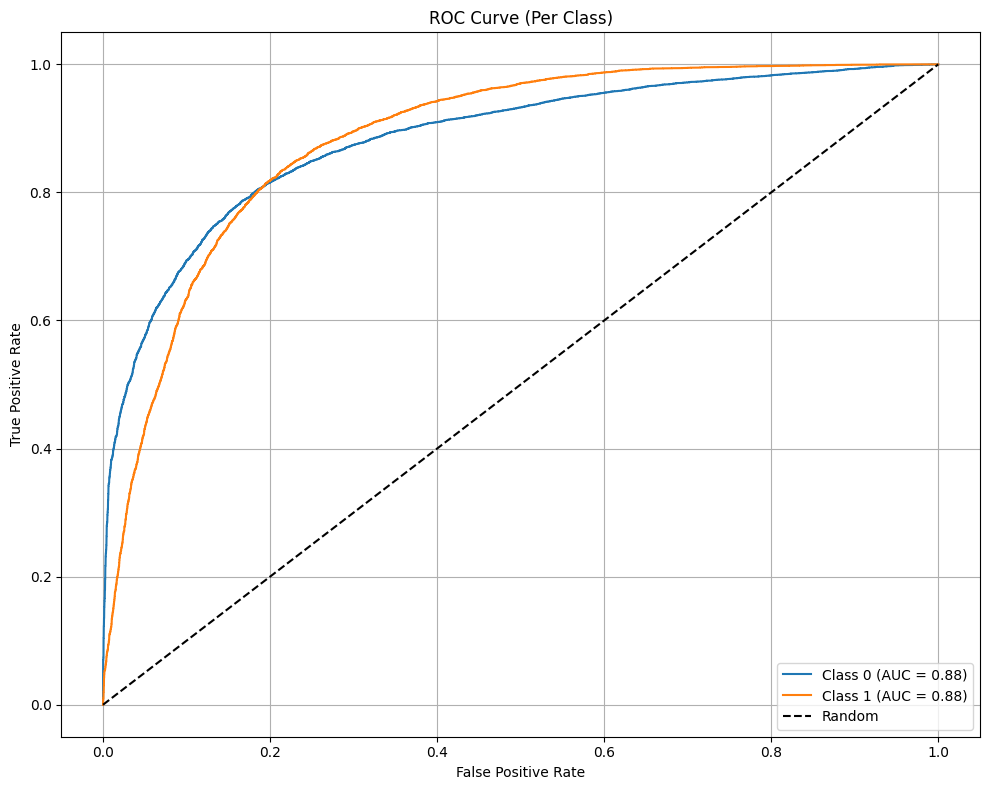

In [10]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure y_test is binarized
n_classes = 2
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

